# **Red Wine Quality Project (M2S3)**

In [4]:
from IPython.display import HTML
display(HTML('<img src="red_wine.png" width="1200">'))

# **Introduction**

### **1. Goal of the Regression Analysis** 🎯
This project analyzes the Red Wine Quality dataset to understand which physicochemical properties most significantly influence perceived wine quality. The dataset contains information about Portuguese "Vinho Verde" red wines, including chemical measurements and expert quality ratings.

The analysis focuses on building an **explanatory linear regression model** to identify the key factors that determine wine quality ratings. This multivariate analysis examines relationships between:

- **Chemical Properties**: Fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, sulfur dioxide levels, density, pH, sulphates, and alcohol content
- **Quality Ratings**: Expert evaluations on a scale from 0-10 (actual range 3-8 in the dataset)  

The primary goal is to quantify how specific wine chemistry characteristics impact quality perceptions, providing insights that could inform winemaking decisions and quality control processes.

### **2. Target Variable and Modeling Approach** 📊

The target variable is **wine quality** (`quality`) representing expert sensory evaluations based on the median rating from at least three wine experts. This ordinal variable ranges from 3 to 8 in our dataset, with most wines rated between 5-6.

**Linear Regression was chosen:**

* **Interpretability:** Linear regression provides easily interpretable coefficients that directly quantify how each chemical property affects wine quality
* **Continuous Treatment:** Although quality ratings are discrete, they represent an ordinal scale with sufficient range to be treated as continuous for regression analysis
* **Hypothesis Testing:** Enables direct statistical testing of relationships through coefficient significance tests and confidence intervals
* **Explanatory Focus:** The project emphasizes understanding relationships rather than maximizing predictive accuracy, making linear regression ideal for coefficient interpretation

**Model Development Strategy:**

**1. Initial Model:** Focus on hypothesis-driven variables (alcohol and volatile acidity) <br>
**2. Expanded Model:** Use backward selection to identify additional significant predictors <br>
**3. Model Comparison:** Evaluate both approaches to understand incremental value of additional variables


### **3. Hypothesis Testing Framework** 🧪

**Null Hypothesis (H₀)**: There is no relationship between alcohol content, volatile acidity, and wine quality (the coefficients of alcohol and volatile acidity in predicting wine quality equal zero).

**Alternative Hypothesis (H₁)**: Higher alcohol content and lower volatile acidity are independently associated with higher perceived wine quality.


## **1. Data loading and initial insepction**

#### **<ins>1.1 Import necessary modules to load, read the data and create the data frame for analysis:</ins>**

This also includes the `red_wine_functions.py` file which is a separate Python file containing all the visualization functions.

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import red_wine_functions as viz

from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

sns.set_theme(style="whitegrid") 

pd.set_option('display.max_columns', None)

In [29]:
np.random.seed(42)

In [34]:
df = pd.read_csv('winequality-red.csv')

#### **<ins>1.2 Display the first few rows and inspect the shape of the data frame:</ins>**

In [35]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [12]:
print(f"Dataset shape: {df.shape}")
df.info()

Dataset shape: (1599, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Pandas will not raise an error when encountering a column with mixed types like this. Instead, it will infer the dtype based on what it can handle. Therefore it is important to verify if each row in a column has the same data type, i.e. the dataset may have errors where accidentally categorical values appear in numerical columns and vice versa. This is just to check that every column also has the same data type for all values:

In [13]:
def check_column_types(df):

    """
    Checks whether each column has consistent data types within each column in case a different data type was pasted in a column where it shouldn't be.
    
    """
    inconsistent_columns = {}

    for column in df.columns:
        if df[column].dtype == 'O': 
            unique_types = df[column].map(type).unique()
            if len(unique_types) > 1:
                inconsistent_columns[column] = unique_types

    return inconsistent_columns

inconsistent_columns = check_column_types(df)

if inconsistent_columns:
    print("Columns with inconsistent data types:")
    for column, types in inconsistent_columns.items():
        print(f"Column: {column} has mixed types: {types}")
else:
    print("\nAll columns have consistent data types!")


All columns have consistent data types!


#### **<ins>1.3 Check for missing values:</ins>**

Missing values can appear in various forms in a dataset, such as:

* NaN (Not a Number)
* Empty cells in the CSV (could be treated as empty strings "" or NaN)
* Missing data can also be reflected as placeholder stings ('/', '-', '--') which need to be accounted for
* Zeros (although this depends on the context - sometimes 0 might be a valid value, other times it’s a placeholder for missing data)

In [14]:
missing_placeholders = ['/', '-', '--']

missing_values = df.isnull()

missing_count = missing_values.sum()

empty_string_count = (df == "").sum()

placeholder_count = df.isin(missing_placeholders).sum()
 
display(pd.DataFrame({'Missing values count': missing_count, 
                      'Empty string count': empty_string_count, 
                      'Placeholder count': placeholder_count}))

if missing_count.sum() == 0 and empty_string_count.sum() == 0 and placeholder_count.sum() == 0:
    print("\nNo missing values, empty strings or placeholders found in any column.")
else:
    print("\nColumns with missing values, empty strings or placeholders: ")
    
    missing_or_placeholder = missing_values | (df == "") | df.isin(missing_placeholders)
    display(missing_or_placeholder[missing_or_placeholder.any()])  

    display(missing_count[missing_count > 0]) 
    display(empty_string_count[empty_string_count > 0])  
    display(placeholder_count[placeholder_count > 0])

Missing values count  Empty string count  \
fixed acidity                            0                   0   
volatile acidity                         0                   0   
citric acid                              0                   0   
residual sugar                           0                   0   
chlorides                                0                   0   
free sulfur dioxide                      0                   0   
total sulfur dioxide                     0                   0   
density                                  0                   0   
pH                                       0                   0   
sulphates                                0                   0   
alcohol                                  0                   0   
quality                                  0                   0   

                      Placeholder count  
fixed acidity                         0  
volatile acidity                      0  
citric acid                           0  
residual sugar                        0  
chlorides                             0  
free sulfur dioxide                   0  
total sulfur dioxide                  0  
density                               0  
pH                                    0  
sulphates                             0  
alcohol                               0  
quality                               0


No missing values, empty strings or placeholders found in any column.


#### **<ins>1.4 Check for zero values:</ins>**

Checking for zeros separetly - sometimes the value '0' may be a valid value, whereas in other caes it can be a missing value. Looking at all columns and identifying certain features where '0' appears:

In [114]:
zero_count = (df.select_dtypes(include='number') == 0).sum()

if zero_count.sum() == 0:
    display("No zeros found in any numeric columns.")
else:
    zero_count_df = zero_count.to_frame(name='Zero Count')
display(zero_count_df)

Zero Count
fixed acidity                  0
volatile acidity               0
citric acid                  132
residual sugar                 0
chlorides                      0
free sulfur dioxide            0
total sulfur dioxide           0
density                        0
pH                             0
sulphates                      0
alcohol                        0
quality                        0

#### **Handling zero values:**

* **Natural Occurrence:** The 132 zero values (8.3% of observations) in citric acid represent a legitimate characteristic of some wines, as citric acid can naturally be absent or present in very small quantities that round to zero in the measurement process, rather than indicating missing data or measurement errors.
* **Decision to Retain:** Zero values were retained in the analysis because citric acid absence is a valid wine chemistry characteristic that could influence quality ratings. Converting zeros to missing values or imputing them would artificially alter the natural chemical composition data.

#### **<ins>1.5 Check for duplicates and data cleaning:</ins>**


#### **Step 1:** Create a copy of the original DataFrame

Strip whitespace and remove hidden characters for all string columns. This preserves the original data in case it needs to be reverted or analyzed further.

The cleaning function can be applied to all columns in the DataFrame, but only to those columns where string operations make sense (i.e.,     for columns with object or string data types).

In [16]:
from IPython.display import display

"""
    Cleans a DataFrame by applying various string cleaning operations to all columns with string data.
    
    This function performs the following operations:
    1. Strips leading/trailing whitespace from all string columns.
    2. Removes hidden characters (e.g., newline or tab characters) from all string columns.
    3. Converts all string columns to lowercase to ensure consistency and avoid case-sensitive duplicates.

    Args:
    df (pandas.DataFrame): The original DataFrame to be cleaned.

    Returns:
    pandas.DataFrame: A cleaned copy of the input DataFrame with all specified string cleaning applied.
    """
def clean_dataframe(df):
 
    df_cleaned = df.copy()
    df_cleaned = df_cleaned.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    df_cleaned = df_cleaned.apply(lambda x: x.str.replace(r'[\n\t]', '', regex=True) if x.dtype == "object" else x)
    df_cleaned = df_cleaned.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
    return df_cleaned

df_cleaned = clean_dataframe(df)

display(df_cleaned.head())

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

#### **Step 2:** After cleaning the data, apply the .duplicated() method to find and remove any duplicates:

In [17]:
import red_wine_functions as viz
import importlib
importlib.reload(viz)
has_duplicates = viz.check_duplicates(df)

Number of duplicate rows: 240
First few duplicate rows:


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
4             7.4             0.700         0.00            1.90      0.076   
11            7.5             0.500         0.36            6.10      0.071   
27            7.9             0.430         0.21            1.60      0.106   
40            7.3             0.450         0.36            5.90      0.074   
65            7.2             0.725         0.05            4.65      0.086   

    free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
4                  11.0                  34.0   0.9978  3.51       0.56   
11                 17.0                 102.0   0.9978  3.35       0.80   
27                 10.0                  37.0   0.9966  3.17       0.91   
40                 12.0                  87.0   0.9978  3.33       0.83   
65                  4.0                  11.0   0.9962  3.41       0.39   

    alcohol  quality  
4       9.4        5  
11     10.5        5  
27      9.5        5  
40     10.5        5  
65     10.9        5

Total rows involved in duplication: 460
Sample of duplicate sets (sorted to show identical rows together):


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
142             5.2              0.34         0.00             1.8      0.050   
144             5.2              0.34         0.00             1.8      0.050   
131             5.6              0.50         0.09             2.3      0.049   
132             5.6              0.50         0.09             2.3      0.049   
1488            5.6              0.54         0.04             1.7      0.049   
1491            5.6              0.54         0.04             1.7      0.049   
996             5.6              0.66         0.00             2.2      0.087   
997             5.6              0.66         0.00             2.2      0.087   
829             5.9              0.61         0.08             2.1      0.071   
831             5.9              0.61         0.08             2.1      0.071   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
142                  27.0                  63.0  0.99160  3.68       0.79   
144                  27.0                  63.0  0.99160  3.68       0.79   
131                  17.0                  99.0  0.99370  3.63       0.63   
132                  17.0                  99.0  0.99370  3.63       0.63   
1488                  5.0                  13.0  0.99420  3.72       0.58   
1491                  5.0                  13.0  0.99420  3.72       0.58   
996                   3.0                  11.0  0.99378  3.71       0.63   
997                   3.0                  11.0  0.99378  3.71       0.63   
829                  16.0                  24.0  0.99376  3.56       0.77   
831                  16.0                  24.0  0.99376  3.56       0.77   

      alcohol  quality  
142      14.0        6  
144      14.0        6  
131      13.0        5  
132      13.0        5  
1488     11.4        5  
1491     11.4        5  
996      12.8        7  
997      12.8        7  
829      11.1        6  
831      11.1        6

#### **Observation:** 

<ins>The dataset indeed contains true duplicates:</ins>

* **240 duplicate rows** where **all features have identical values** to a previous row
* A total of **460 rows involved in duplication** (this includes **both the first occurrences and subsequent duplicates**)
* Clear examples of exact duplicates like rows 142 and 144, which have identical values across all columns

<ins>For a wine quality analysis, these duplicates could be problematic for several reasons:</ins>

* **Statistical independence assumption:** Most statistical models assume each observation is independent. Duplicates violate this assumption by * essentially counting the same observation multiple times.
* **Model bias:** Including duplicates could bias your model toward the characteristics of those duplicated samples.
* **Data leakage in training/testing:** If duplicates are split between training and testing sets, this creates data leakage where the model sees the same exact data in both sets.

**Solution:** Removing these duplicates by keeping only the first occurrence of each unique combination of features:

Original dataset size: 1599 rows
After removing duplicates: 1359 rows
Removed 240 duplicate rows

Quality distribution in original dataset:
quality
3     0.625391
4     3.314572
5    42.589118
6    39.899937
7    12.445278
8     1.125704
Name: proportion, dtype: float64

Quality distribution after removing duplicates:
quality
3     0.735835
4     3.899926
5    42.457689
6    39.367182
7    12.288447
8     1.250920
Name: proportion, dtype: float64

Difference in percentage points:
quality
3    0.110444
4    0.585355
5   -0.131429
6   -0.532756
7   -0.156831
8    0.125216
Name: proportion, dtype: float64


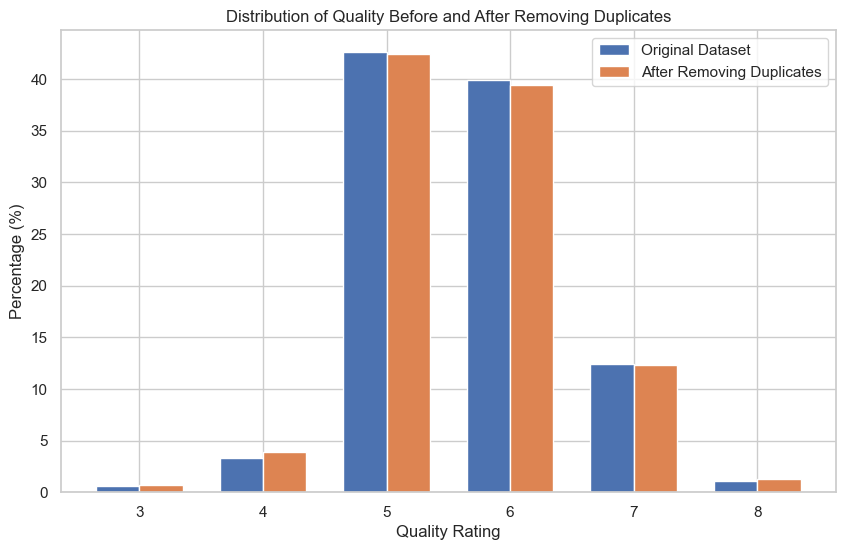

In [108]:
if has_duplicates:
    importlib.reload(viz)
    df2 = viz.remove_duplicates_and_compare(df)

**Summary:**

The differences are very small (e.g., less than 1-2 percentage points for each quality level), which means removing duplicates has not significantly affected the distribution of your target variable.

#### **<ins>1.6 Outlier Analysis (Z-score):</ins>**

**Justification for Using Z-Score Method:**

* **Appropriate for the key variables:** The main variables of interest (alcohol and volatile acidity) show reasonably normal distributions with skewness values of 0.81 and 0.77, respectively. Z-score is most effective for approximately normally distributed data.
* **Statistical interpretation:** Z-scores have a clear statistical interpretation - they represent the number of standard deviations a data point is from the mean. Using a threshold of 3 means identifying points that have less than 0.3% probability of occurring in a normal distribution.
* **Balanced approach:** Compared to IQR, the Z-score method tends to be less aggressive in removing data points from variables with near-normal distributions. This helps preserve more data for analysis while still removing true outliers.
* **Connection to regression assumptions:** Linear regression models assume normally distributed errors, and removing Z-score outliers can help improve this normality.
* **Focus on explanatory modeling:** Since the goal is an explanatory model rather than prediction, preserving as many valid data points as possible while removing only extreme outliers aligns with the objective of understanding variable relationships.

## Z-score Outlier Analysis (threshold = 3.0)

### Outliers by Column

Column  Outliers Percentage
3         residual sugar        28      2.06%
4              chlorides        27      1.99%
9              sulphates        21      1.55%
5    free sulfur dioxide        18      1.32%
7                density        13      0.96%
6   total sulfur dioxide        12      0.88%
11               quality        10      0.74%
0          fixed acidity         9      0.66%
1       volatile acidity         9      0.66%
8                     pH         8      0.59%
10               alcohol         7      0.52%
2            citric acid         1      0.07%

### Overall Summary

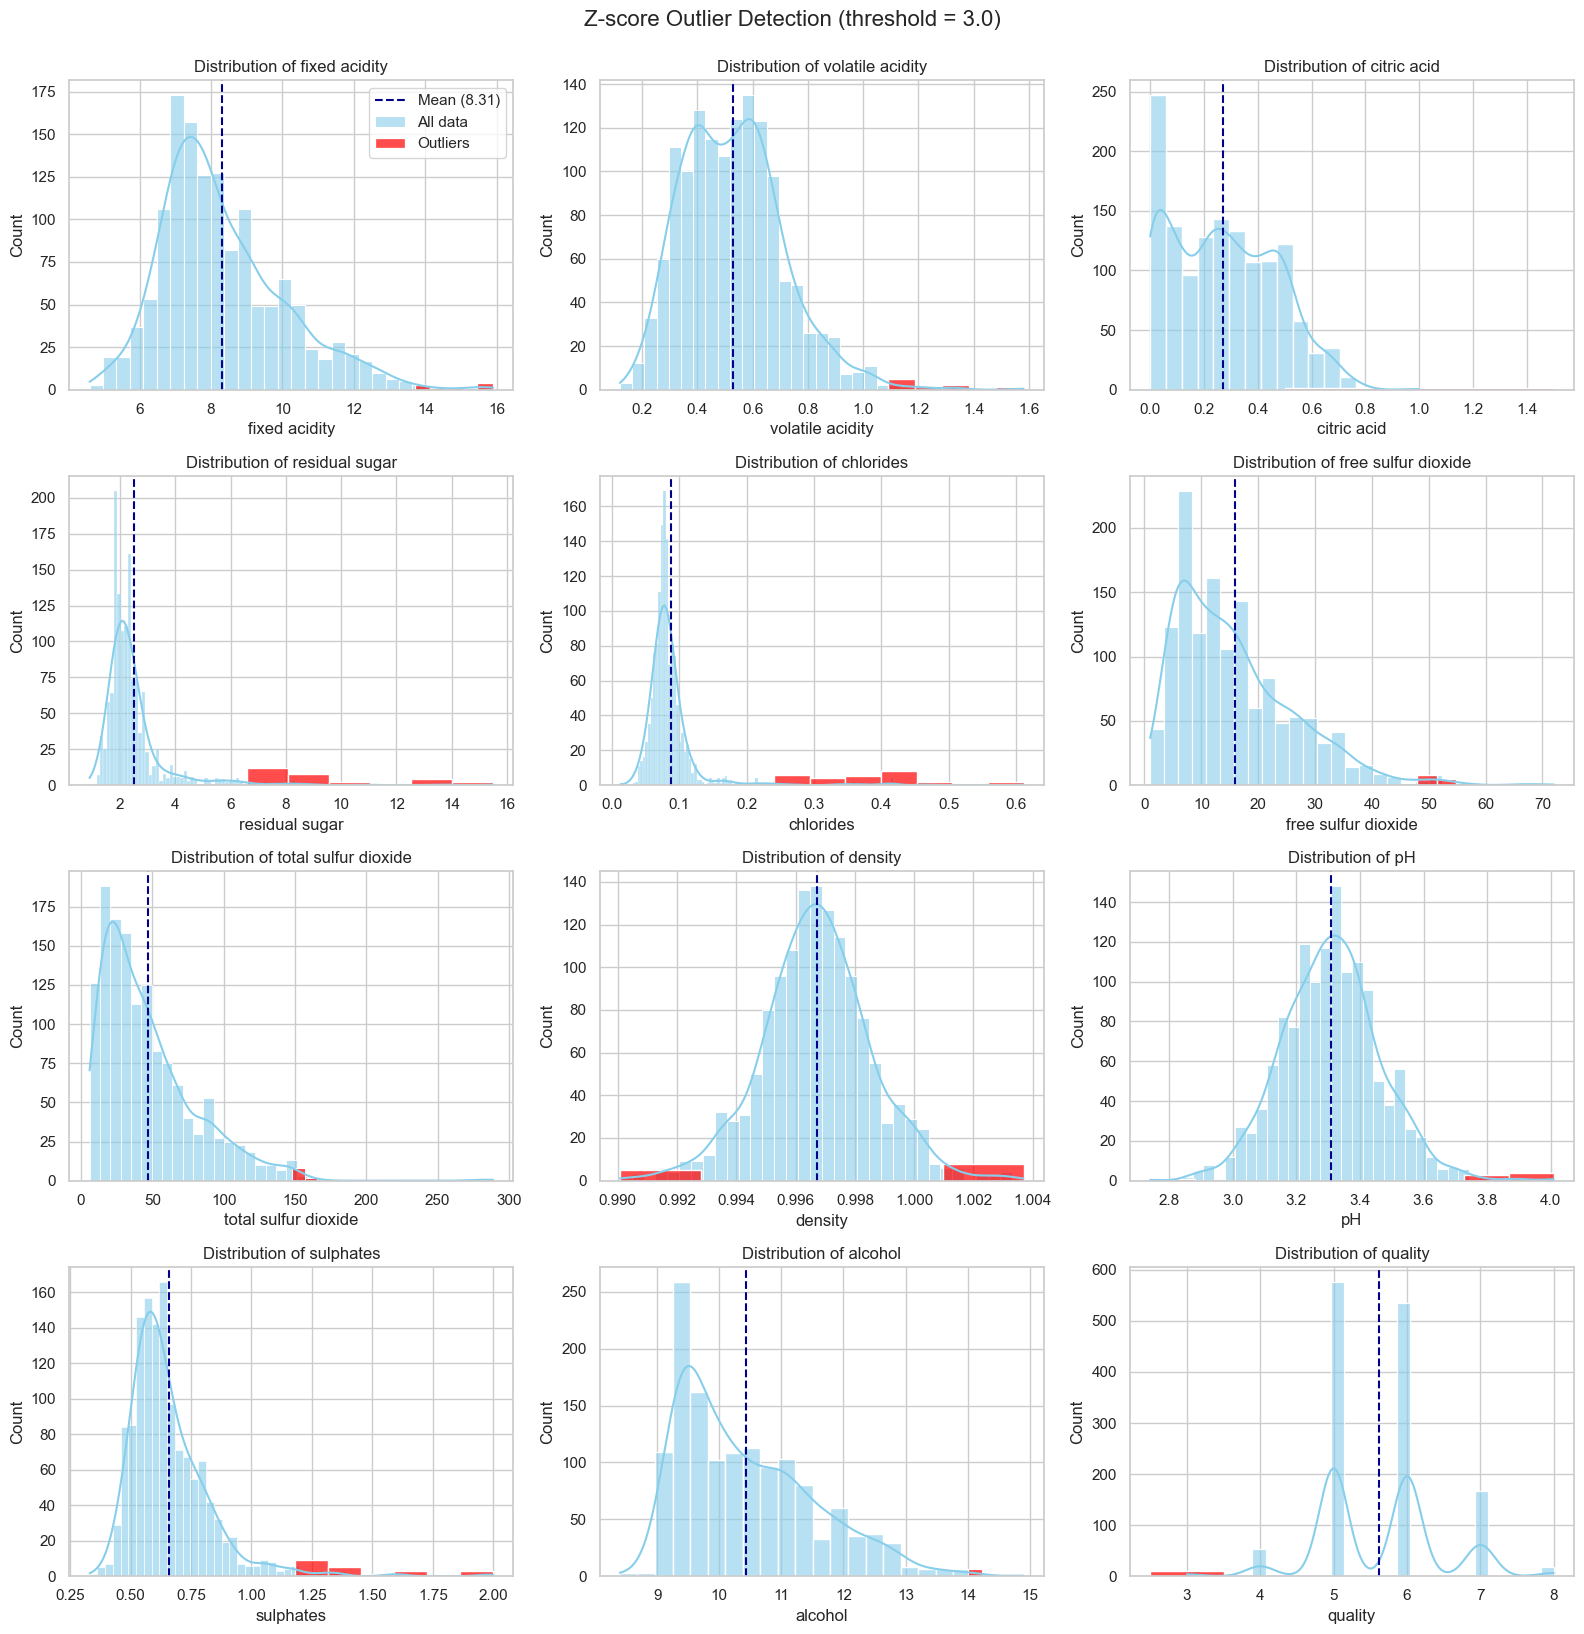

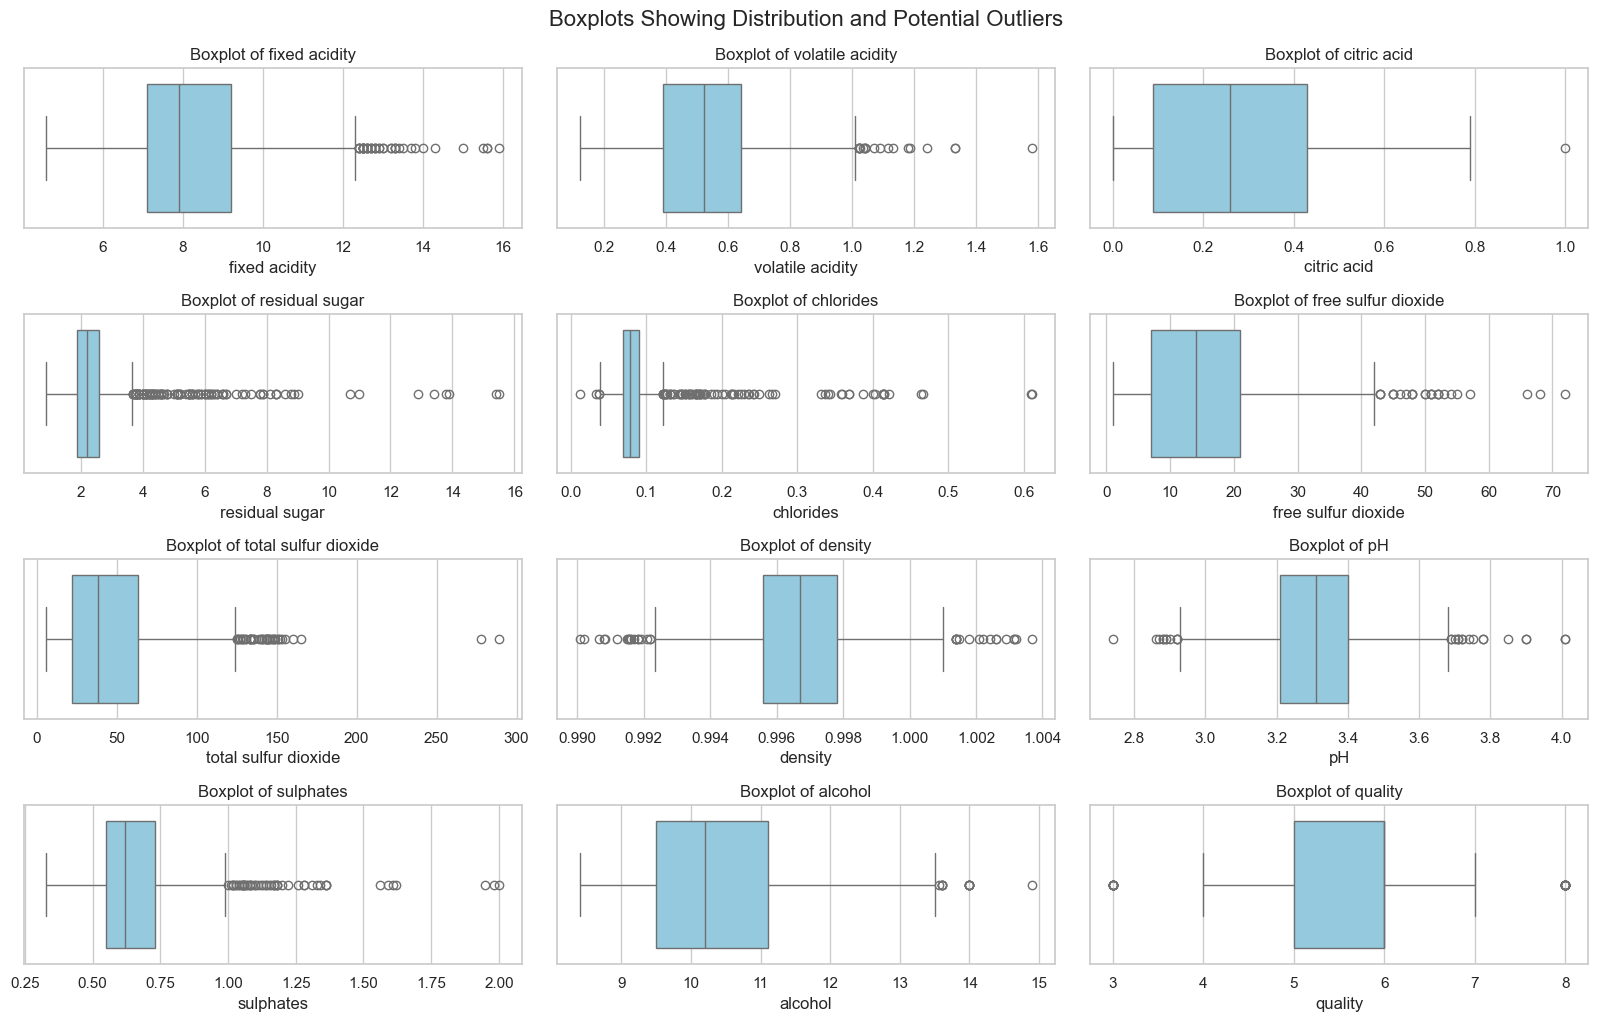

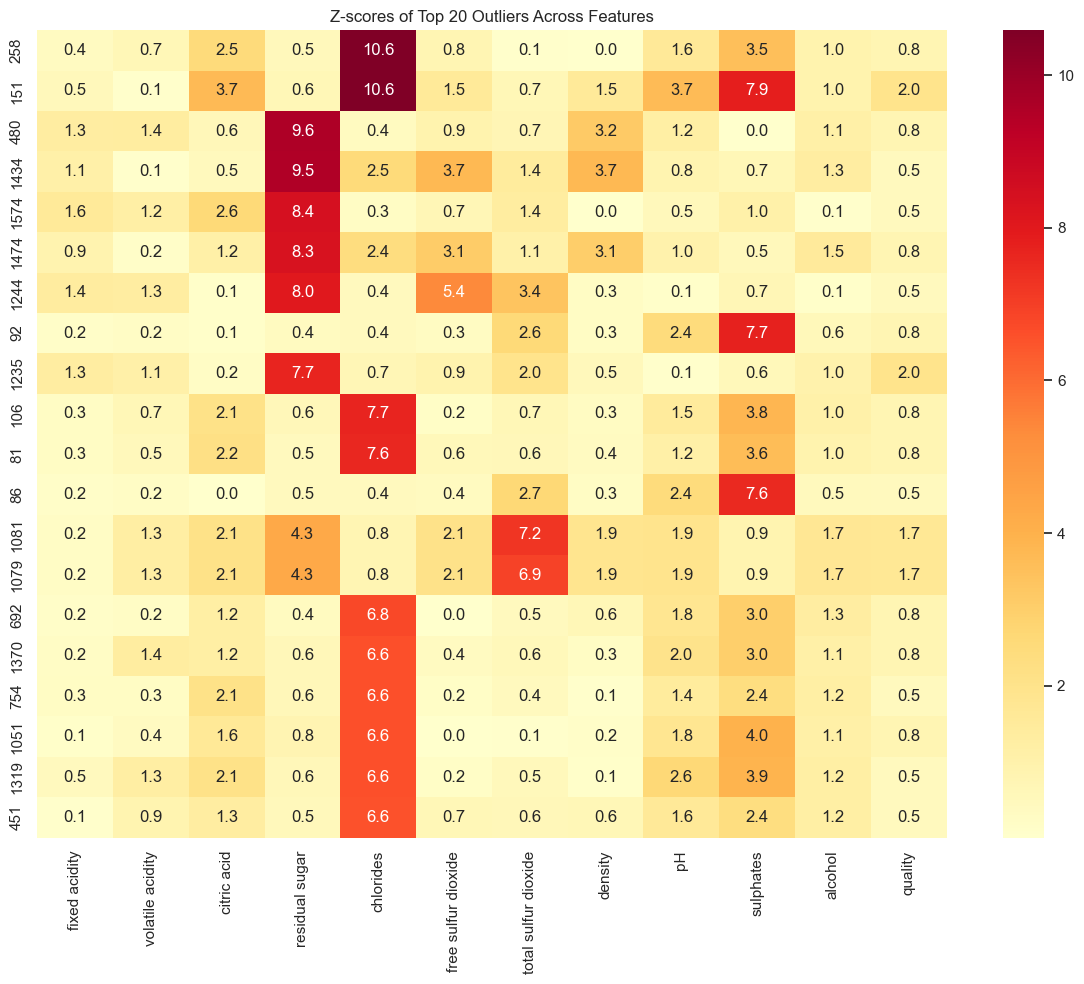

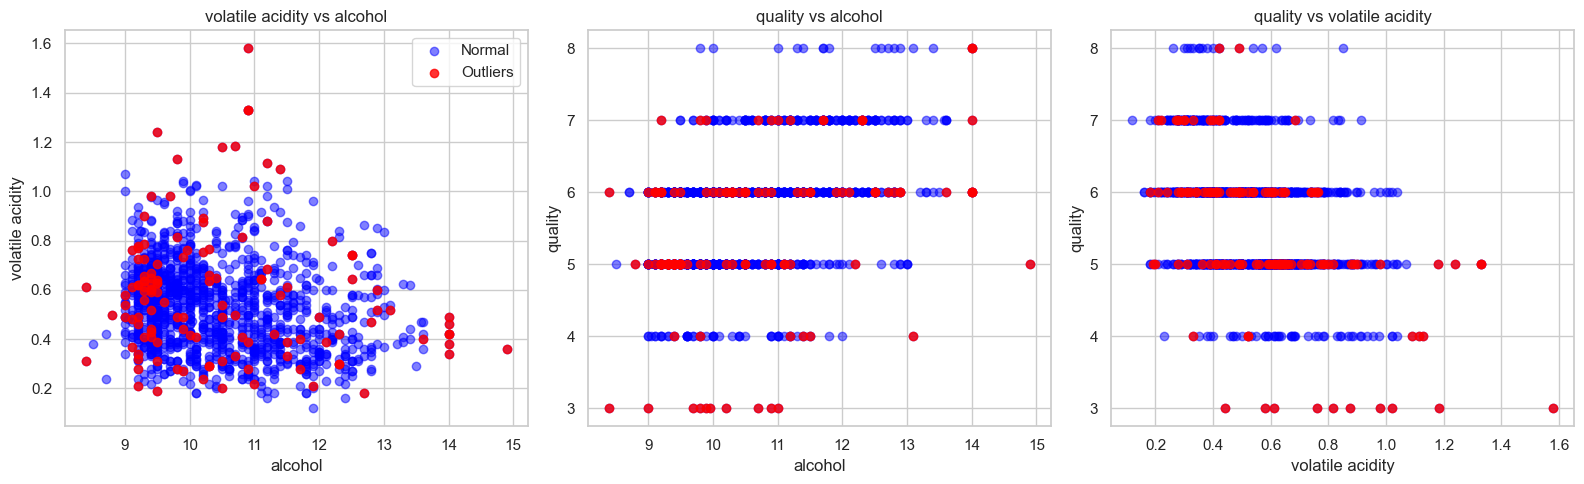

### Sample of Identified Outliers

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
13            7.8             0.610         0.29             1.6      0.114   
14            8.9             0.620         0.18             3.8      0.176   
15            8.9             0.620         0.19             3.9      0.170   
17            8.1             0.560         0.28             1.7      0.368   
19            7.9             0.320         0.51             1.8      0.341   
33            6.9             0.605         0.12            10.7      0.073   
38            5.7             1.130         0.09             1.5      0.172   
42            7.5             0.490         0.20             2.6      0.332   
43            8.1             0.660         0.22             2.2      0.069   
45            4.6             0.520         0.15             2.1      0.054   

    free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
13                  9.0                  29.0   0.9974  3.26       1.56   
14                 52.0                 145.0   0.9986  3.16       0.88   
15                 51.0                 148.0   0.9986  3.17       0.93   
17                 16.0                  56.0   0.9968  3.11       1.28   
19                 17.0                  56.0   0.9969  3.04       1.08   
33                 40.0                  83.0   0.9993  3.45       0.52   
38                  7.0                  19.0   0.9940  3.50       0.48   
42                  8.0                  14.0   0.9968  3.21       0.90   
43                  9.0                  23.0   0.9968  3.30       1.20   
45                  8.0                  65.0   0.9934  3.90       0.56   

    alcohol  quality  
13      9.1        5  
14      9.2        5  
15      9.2        5  
17      9.3        5  
19      9.2        6  
33      9.4        6  
38      9.8        4  
42     10.5        6  
43     10.3        5  
45     13.1        4

Original data: 1359 rows
After removing 127 outliers: 1232 rows


In [107]:
import importlib
importlib.reload(viz)

z_outliers, z_indices = viz.get_zscore_outliers(df2)

df3 = df2.drop(index=z_indices)
print(f"Original data: {len(df2)} rows")
print(f"After removing {len(z_indices)} outliers: {len(df2_no_outliers)} rows")

#### **Summary of findings:**

**<ins>Visual Analysis Confirmation of tabular findings:</ins>**

* **Box plots:** Clear extreme points beyond the whiskers for residual sugar and chlorides
* **Histograms:** Right-skewed distributions with long tails for the features with highest outlier counts
* **Heatmap:** Concentration of extreme Z-scores (dark red) in specific wine samples, validating the systematic nature of outlier identification

**<ins>Findings:</ins>**

**Heatmap Analysis**

* **Multi-feature Outliers:** The heatmap shows specific wine samples (row indices like 451, 1319) with multiple extreme Z-scores across different features, indicating certain wines have several unusual chemical properties simultaneously rather than isolated measurement errors.
* **Feature Concentration:** Residual sugar and chlorides show the most frequent extreme values (dark red cells), confirming these are the most variable chemical properties in the dataset.

**Box Plots and Histograms**

* **Distribution Confirmation:** Box plots visually confirm the tabular results, with residual sugar and chlorides showing the most extreme outliers beyond the whiskers, while alcohol and citric acid display tighter, more consistent ranges.
* **Skewness Patterns:** Histograms reveal right-skewed distributions for the features with highest outlier counts, explaining why Z-score method was more appropriate than IQR for identifying truly extreme values in these chemical measurements.

**Relationship Plots (Alcohol vs. Quality, Volatile Acidity vs. Quality)**

* **Extreme Value Isolation:** Red outlier points appear as isolated cases at the edges of the main data clusters, particularly wines with very high volatile acidity (>1.2) or extreme alcohol content (>14%), which could skew linear regression relationships.
* **Hypothesis Protection:** Removing these outliers preserves the linear patterns needed for reliable coefficient estimation in your hypothesis testing, ensuring results reflect typical wine chemistry rather than production anomalies.

#### **Dataframe summary:**


**`df`** - Original dataframe 
**`df2`** - After removing duplicates
**`df3`** - After removing duplicates + outliers

#### **Comparision between `df2` and `df3` dataset:**

After identifying and removing outliers, it's important to understand how this affects our dataset's distributions and relationships. The following analysis compares our dataset before (df2) and after (df3) outlier removal to ensure our key insights remain valid.

## Comparing With Outliers (df2) (1359 rows) with Without Outliers (df3) (1232 rows)

* Difference: 127 rows (9.35% reduction)

### Summary Statistics Comparison

With Outliers (df2) Mean  Without Outliers (df3) Mean  \
fixed acidity                            8.311                        8.303   
volatile acidity                         0.529                        0.524   
citric acid                              0.272                        0.266   
residual sugar                           2.523                        2.377   
chlorides                                0.088                        0.082   
free sulfur dioxide                     15.893                       15.186   
total sulfur dioxide                    46.826                       44.354   
density                                  0.997                        0.997   
pH                                       3.310                        3.313   
sulphates                                0.659                        0.642   
alcohol                                 10.432                       10.426   
quality                                  5.623                        5.647   

                     Mean % Change  With Outliers (df2) Std  \
fixed acidity               -0.09%                    1.737   
volatile acidity            -1.01%                    0.183   
citric acid                 -2.23%                    0.196   
residual sugar               -5.8%                    1.352   
chlorides                   -7.29%                    0.049   
free sulfur dioxide         -4.45%                   10.447   
total sulfur dioxide        -5.28%                   33.409   
density                      -0.0%                    0.002   
pH                           0.11%                    0.155   
sulphates                   -2.51%                    0.171   
alcohol                     -0.06%                    1.082   
quality                      0.42%                    0.824   

                      Without Outliers (df3) Std Std % Change  \
fixed acidity                              1.649       -5.06%   
volatile acidity                           0.172       -6.04%   
citric acid                                0.191       -2.45%   
residual sugar                             0.824      -39.09%   
chlorides                                  0.022      -54.57%   
free sulfur dioxide                        9.335      -10.65%   
total sulfur dioxide                      30.052      -10.05%   
density                                    0.002       -8.29%   
pH                                         0.141       -9.09%   
sulphates                                  0.130      -23.87%   
alcohol                                    1.038       -4.03%   
quality                                    0.793       -3.76%   

                      With Outliers (df2) Min  Without Outliers (df3) Min  \
fixed acidity                           4.600                       5.000   
volatile acidity                        0.120                       0.120   
citric acid                             0.000                       0.000   
residual sugar                          0.900                       1.200   
chlorides                               0.012                       0.038   
free sulfur dioxide                     1.000                       1.000   
total sulfur dioxide                    6.000                       6.000   
density                                 0.990                       0.992   
pH                                      2.740                       2.880   
sulphates                               0.330                       0.330   
alcohol                                 8.400                       8.500   
quality                                 3.000                       4.000   

                      With Outliers (df2) Max  Without Outliers (df3) Max  
fixed acidity                          15.900                      13.500  
volatile acidity                        1.580                       1.070  
citric acid                             1.000                       0.790  
residual sugar        

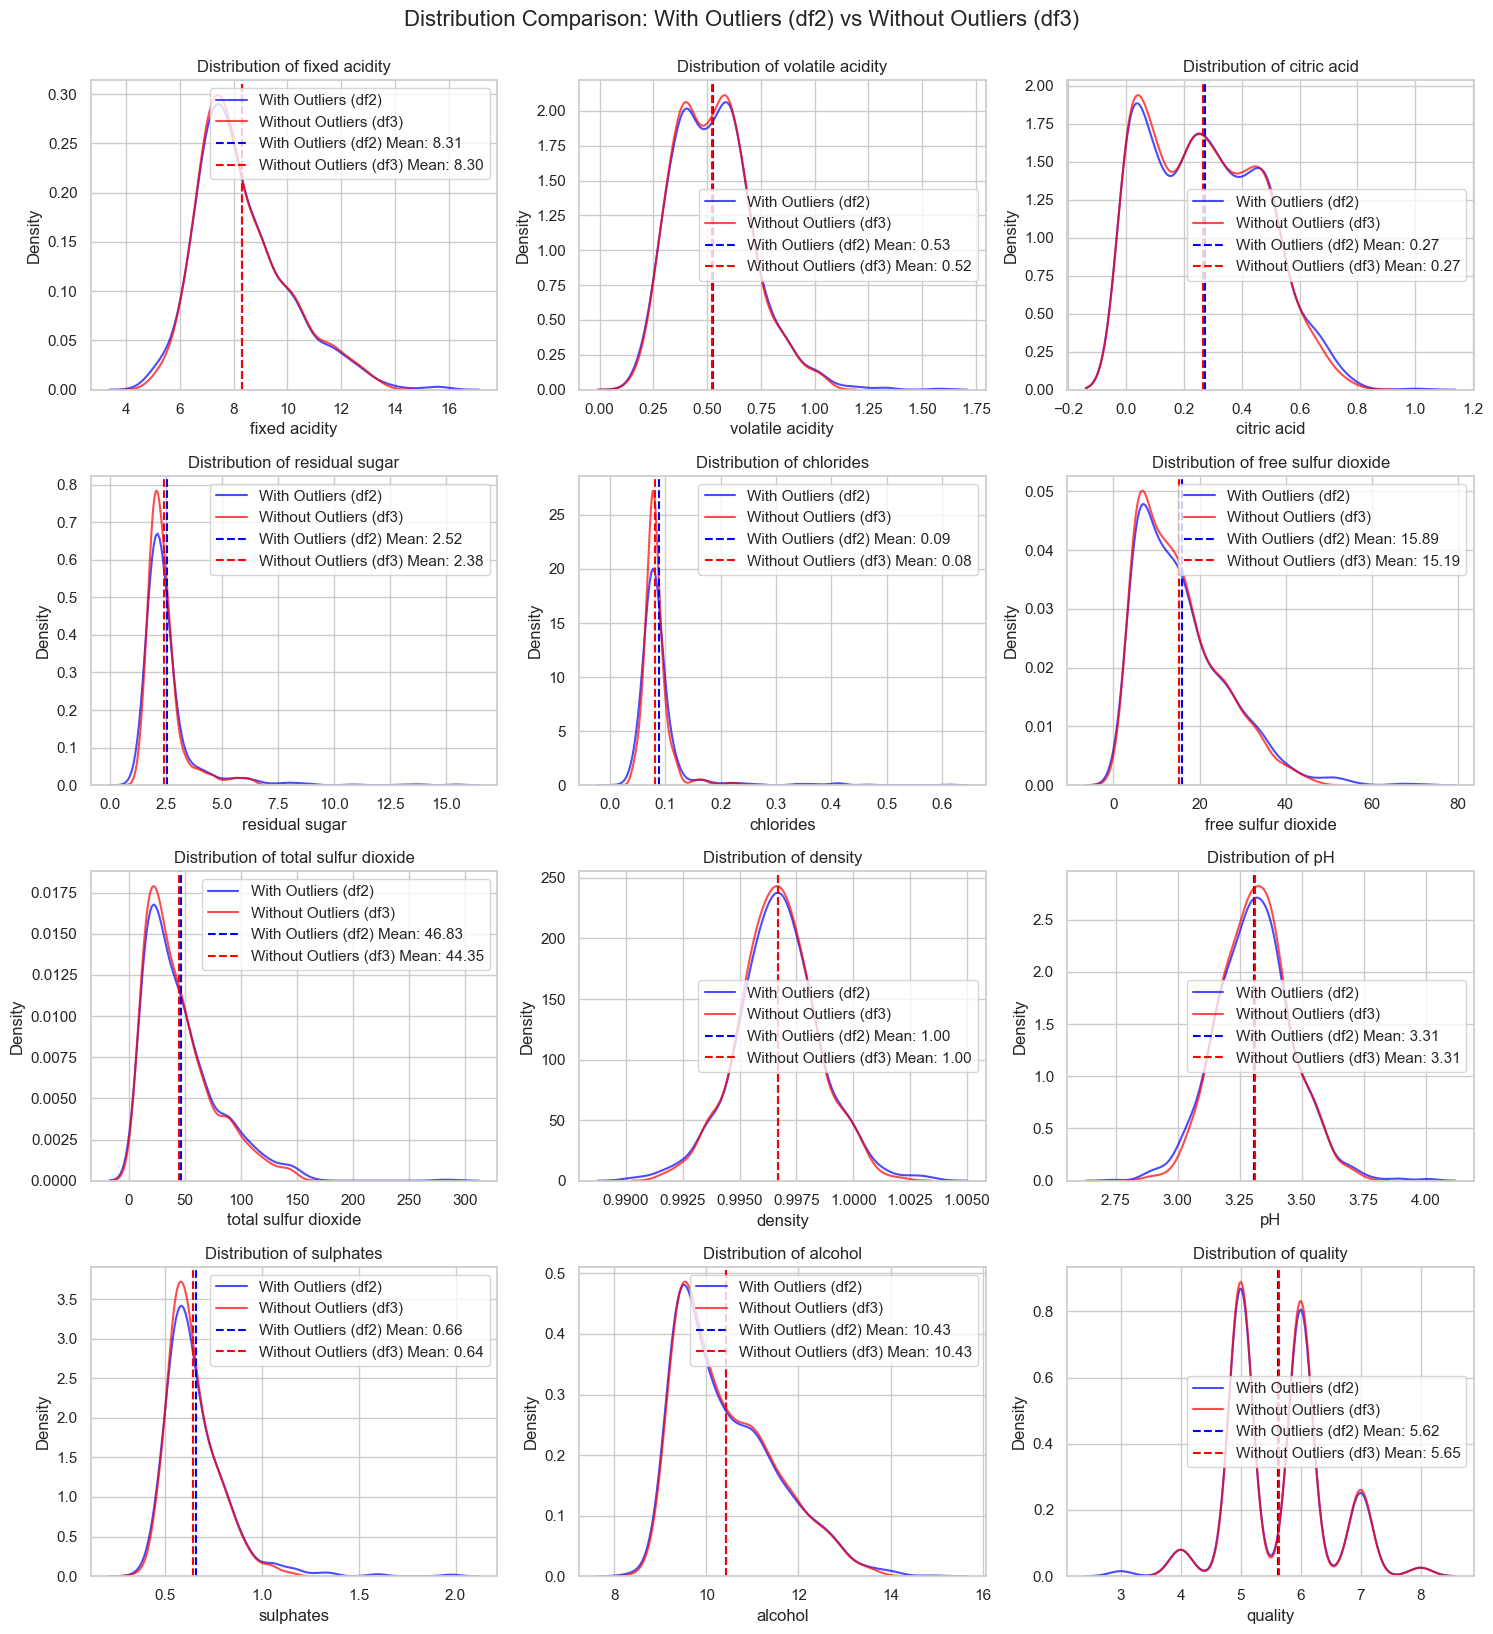

### Correlation with Quality

With Outliers (df2) Correlation  \
alcohol                                         0.480   
sulphates                                       0.249   
volatile acidity                               -0.395   
citric acid                                     0.228   
total sulfur dioxide                           -0.178   
density                                        -0.184   
fixed acidity                                   0.119   
chlorides                                      -0.131   
pH                                             -0.055   
free sulfur dioxide                            -0.050   
residual sugar                                  0.014   

                      Without Outliers (df3) Correlation  Absolute Change  \
alcohol                                            0.506            0.025   
sulphates                                          0.386            0.137   
volatile acidity                                  -0.360            0.035   
citric acid                                        0.246            0.018   
total sulfur dioxide                              -0.240           -0.062   
density                                           -0.179            0.005   
fixed acidity                                      0.142            0.023   
chlorides                                         -0.120            0.011   
pH                                                -0.079           -0.024   
free sulfur dioxide                               -0.076           -0.026   
residual sugar                                     0.052            0.039   

                     Percentage Change  
alcohol                           5.3%  
sulphates                        55.1%  
volatile acidity                  9.0%  
citric acid                       7.7%  
total sulfur dioxide            -34.7%  
density                           2.8%  
fixed acidity                    19.5%  
chlorides                         8.6%  
pH                              -42.9%  
free sulfur dioxide             -51.2%  
residual sugar                  282.8%

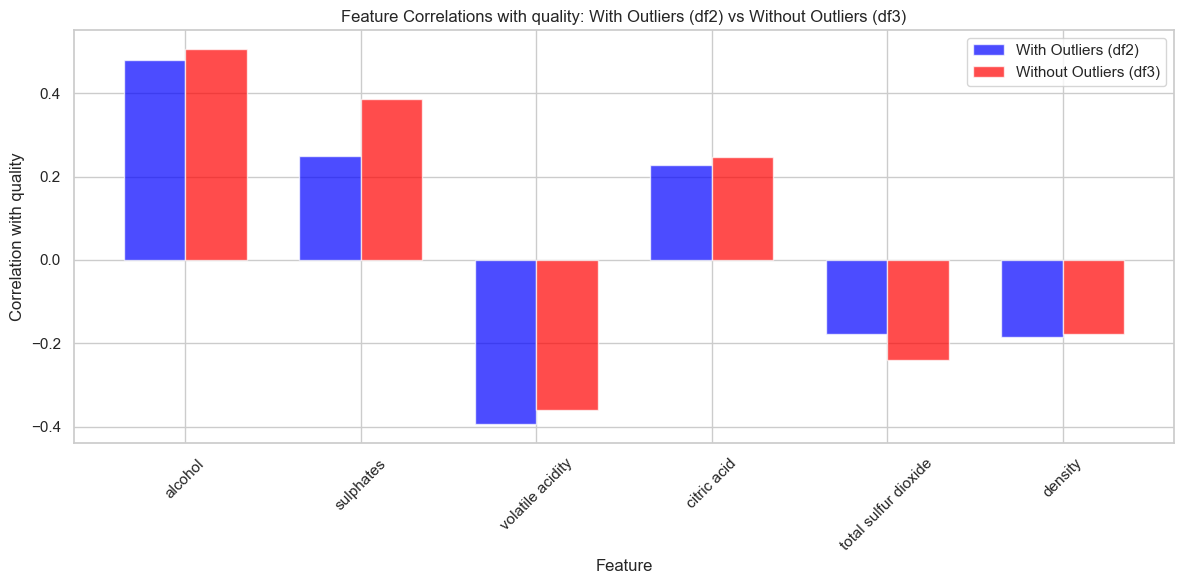

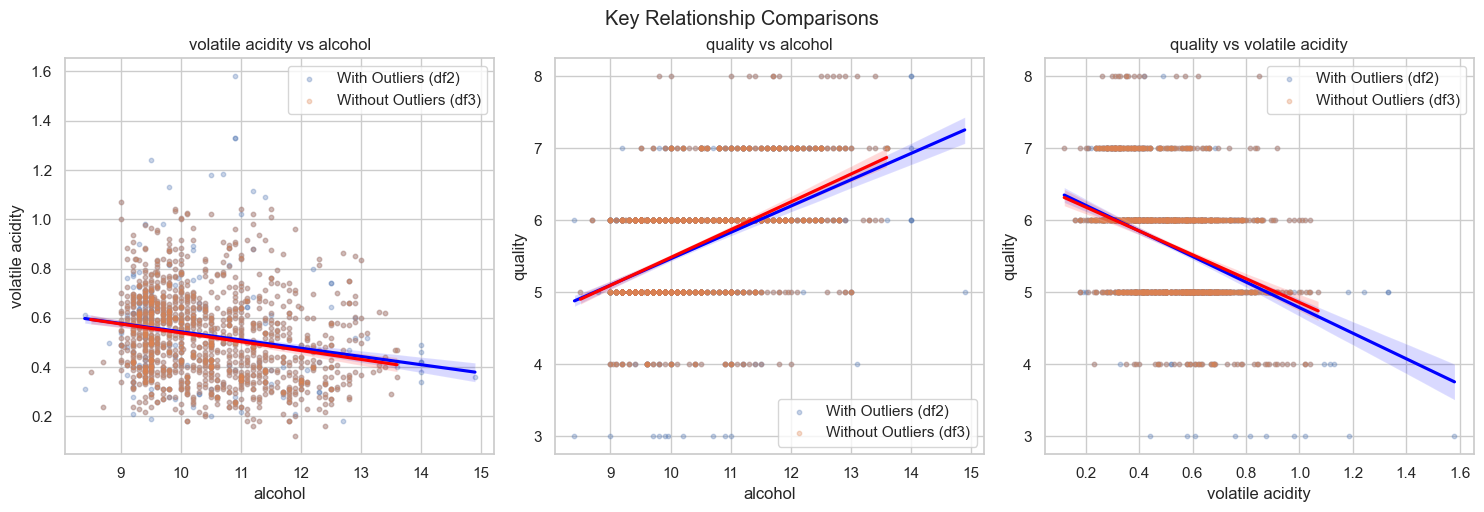

In [96]:
import importlib
importlib.reload(viz)
viz.compare_dataframes(df2, df3, name1='With Outliers (df2)', name2='Without Outliers (df3)')

#### **Analysis of `df2` vs `df3` Comparison:**

**<ins>1. Means:</ins>** Most variables show only small changes in their means after removing outliers, suggesting that outliers weren't drastically skewing central tendencies.<br>
**<ins>2. Standard Deviations:</ins>** Significant reductions in standard deviations, particularly for:

**Chlorides:** -54.57%<br>
**Residual sugar:** -39.09%<br>
**Sulphates:** -23.87%<br>
        
This indicates that outliers were indeed inflating the spread of these variables.


**<ins>3. Min/Max Values:</ins>** The maximum values decreased substantially for several variables:

**Fixed acidity:** 15.900 → 13.500<br>
**Volatile acidity:** 1.580 → 1.070<br>
**Chlorides:** 0.611 → 0.236<br>
**Residual sugar:** 15.500 → 6.550<br>

This confirms that extreme high values were identified and removed as outliers.


**<ins>4. Quality:</ins>** The minimum quality increased from 3 to 4, suggesting that some of the lowest-rated wines were outliers. The mean quality increased slightly (+0.42%), indicating that the removed outliers were slightly biased toward lower-quality wines.

#### **<ins>Correlation Changes:</ins>**

**1. Strengthened positive correlations:**

**Sulphates:** +55.1% (from 0.249 to 0.386)<br>
**Alcohol:** +5.3% (from 0.480 to 0.506)

These variables became more strongly associated with quality after outlier removal.


**2. Moderated negative correlations:**

**Volatile acidity:** -0.395 → -0.360 (9.0% change)

The negative relationship is still strong but slightly less pronounced.


**3. Most dramatic change:** Residual sugar correlation with quality increased by 282.8% (from almost zero at 0.014 to a weak positive correlation of 0.052).

#### **<ins>Implications for the Analysis:</ins>**

**1. Use `df3` for Modeling:** The changes support using df3 (without outliers) for your regression model:

* **Standard deviations decreased significantly**, which should help meet regression assumptions
* **Correlations with quality became clearer** for key variables like alcohol and sulphates
* The extreme values that could unduly influence regression coefficients are now removed

#### **<ins>1.7 Summary statistics:</ins>**

Basic Summary Statistics:


fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1232.000000       1232.000000  1232.000000     1232.000000   
mean        8.303328          0.524144     0.266266        2.376948   
std         1.649113          0.171969     0.190753        0.823759   
min         5.000000          0.120000     0.000000        1.200000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.200000          0.636250     0.420000        2.600000   
max        13.500000          1.070000     0.790000        6.550000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1232.000000          1232.000000           1232.000000  1232.000000   
mean      0.081702            15.185877             44.353896     0.996673   
std       0.022433             9.335015             30.051752     0.001714   
min       0.038000             1.000000              6.000000     0.991500   
25%       0.070000             7.000000             21.000000     0.995600   
50%       0.079000            13.000000             37.000000     0.996680   
75%       0.089000            21.000000             60.000000     0.997800   
max       0.236000            47.000000            147.000000     1.002200   

                pH    sulphates      alcohol      quality  
count  1232.000000  1232.000000  1232.000000  1232.000000  
mean      3.313360     0.642192    10.425785     5.646916  
std       0.140937     0.129924     1.038477     0.792639  
min       2.880000     0.330000     8.500000     4.000000  
25%       3.220000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.710000    11.100000     6.000000  
max       3.750000     1.170000    13.600000     8.000000


Additional Statistics:


Median  Skewness   Kurtosis  Missing Values  \
fixed acidity          7.90000  0.807145   0.240482               0   
volatile acidity       0.52000  0.433613  -0.099727               0   
citric acid            0.25000  0.276303  -0.929740               0   
residual sugar         2.20000  2.374715   7.060692               0   
chlorides              0.07900  2.464749  11.195042               0   
free sulfur dioxide   13.00000  0.867289   0.125798               0   
total sulfur dioxide  37.00000  1.162598   0.884886               0   
density                0.99668  0.017683   0.177647               0   
pH                     3.31000  0.118752   0.003703               0   
sulphates              0.62000  0.950578   1.028825               0   
alcohol               10.20000  0.767349  -0.213725               0   
quality                6.00000  0.402697  -0.067769               0   

                      Missing (%)  
fixed acidity                 0.0  
volatile acidity              0.0  
citric acid                   0.0  
residual sugar                0.0  
chlorides                     0.0  
free sulfur dioxide           0.0  
total sulfur dioxide          0.0  
density                       0.0  
pH                            0.0  
sulphates                     0.0  
alcohol                       0.0  
quality                       0.0


Wine Quality Distribution:


Count  Percentage (%)
quality                       
4           47            3.81
5          525           42.61
6          491           39.85
7          154           12.50
8           15            1.22

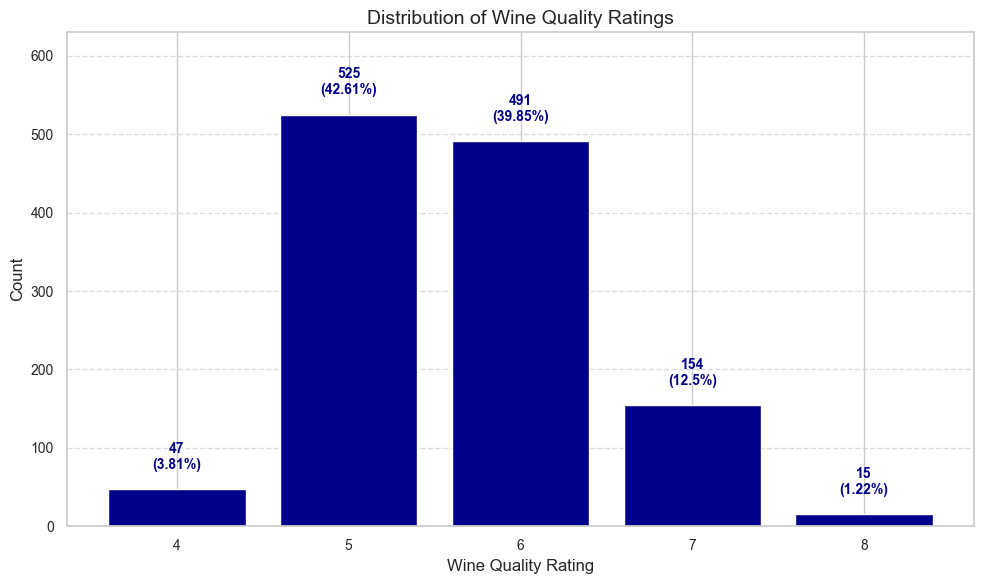

In [97]:
importlib.reload(viz)
viz.display_summary_statistics(df3)

#### **Summary Statistics Key Insights:**

* **Quality Distribution Imbalance:** The dataset is heavily concentrated in average quality wines (5-6 ratings comprise 82.5% of samples), with very few excellent wines (quality 8 = 1.22%) or poor wines (quality 4 = 3.81%), which may limit the model's ability to predict extreme quality ratings accurately.
* **Chemical Property Ranges:** After outlier removal, chemical properties show reasonable ranges for typical wine production (alcohol: 8.5-13.6%, pH: 2.88-3.75), with standard deviations indicating sufficient variation for meaningful regression analysis while maintaining realistic wine chemistry boundaries.

### **2. Data Description**

#### **<ins>2.1 Overview of the original Dataset:</ins>**

The Wine Quality dataset contains physicochemical and sensory data for **1,599 samples of Portuguese "Vinho Verde" red wine**. This dataset was created by Paulo Cortez, António Cerdeira, Fernando Almeida, Telmo Matos, and José Reis in 2009, as documented in their paper "Modeling wine preferences by data mining from physicochemical properties." (https://www.sciencedirect.com/science/article/pii/S0167923609001377)

#### **<ins>2.2 Variable Description:</ins>**

There are 12 variables in the dataset:

**1. fixed acidity:** The concentration of non-volatile acids in the wine (primarily tartaric acid), measured in g/dm³. These acids come primarily from grapes and remain relatively stable throughout the winemaking process.

**2. volatile acidity:** The amount of acetic acid in the wine, measured in g/dm³. High levels of volatile acidity can lead to an unpleasant vinegar taste.

**3. citric acid:** The concentration of citric acid in the wine, measured in g/dm³. Citric acid can add freshness and flavor to wines when present in small quantities.

**4. residual sugar:** The amount of sugar remaining after fermentation stops, measured in g/dm³. It's rare to find wines with less than 1 g/L, and wines with greater than 45 g/L are considered sweet.

**5. chlorides:** The salt content in the wine, measured in g/dm³. High chloride concentrations can give wine a salty taste.

**6. free sulfur dioxide:** The free form of SO₂ that exists in equilibrium between molecular SO₂ and bisulfite ion, measured in mg/dm³. It prevents microbial growth and oxidation.

**7. total sulfur dioxide:** The sum of free and bound forms of SO₂, measured in mg/dm³. In low concentrations, SO₂ is mostly undetectable in wines, but at free SO₂ concentrations over 50 ppm, it becomes evident in the nose and taste of wine.

**8. density:** The density of the wine, measured in g/cm³. This is close to that of water depending on the alcohol and sugar content.

**9. pH:** Describes how acidic or basic the wine is on a scale from 0 (very acidic) to 14 (very basic). Most wines are between 3-4 on the pH scale.

**10. sulphates:** The amount of potassium sulphate in the wine, measured in g/dm³. Sulphates act as an antimicrobial and antioxidant.

**11. alcohol:** The percentage of alcohol content in the wine by volume.

**12. quality:** The target variable, based on sensory data. It's the median of at least 3 evaluations made by wine experts, rated on a scale from 0 (very bad) to 10 (excellent).

#### **<ins>2.3 Data Collection Methodology:</ins>**

The data was collected from **May 2004 to February 2007** and includes only physicochemical and sensory variables. Due to privacy and logistical issues, there is no data about grape types, wine brand, wine selling price, or other variables that would require expert wine knowledge to categorize.
The quality ratings were given by at least three wine experts who evaluated the wines considering several sensory aspects. The final quality rating is the median of these evaluations.

#### **<ins>2.4 Key Characteristics of the Dataset:</ins>**

* **Sample size:** 1,599 red wine samples (1359 samples after removing duplicates, 1232 samples without outliers in addition)
* **Time period:** 2004-2007
* **Source:** Vinho Verde DOC region in Portugal
* **Type:** All samples are red variants of the Portuguese "Vinho Verde" wine
* **Quality distribution:** The classes are ordered and not balanced (there are many more normal wines than excellent or poor ones)
* **Nature of data:** This dataset can be used for both regression (predicting the quality score) or classification (categorizing wines as good/not good)

### **3. Exploratory Data Analysis (EDA)**

#### **<ins>3.1 Univariant Analysis:</ins>**

#### **3.1.1 Numerical Variables Distribution:**

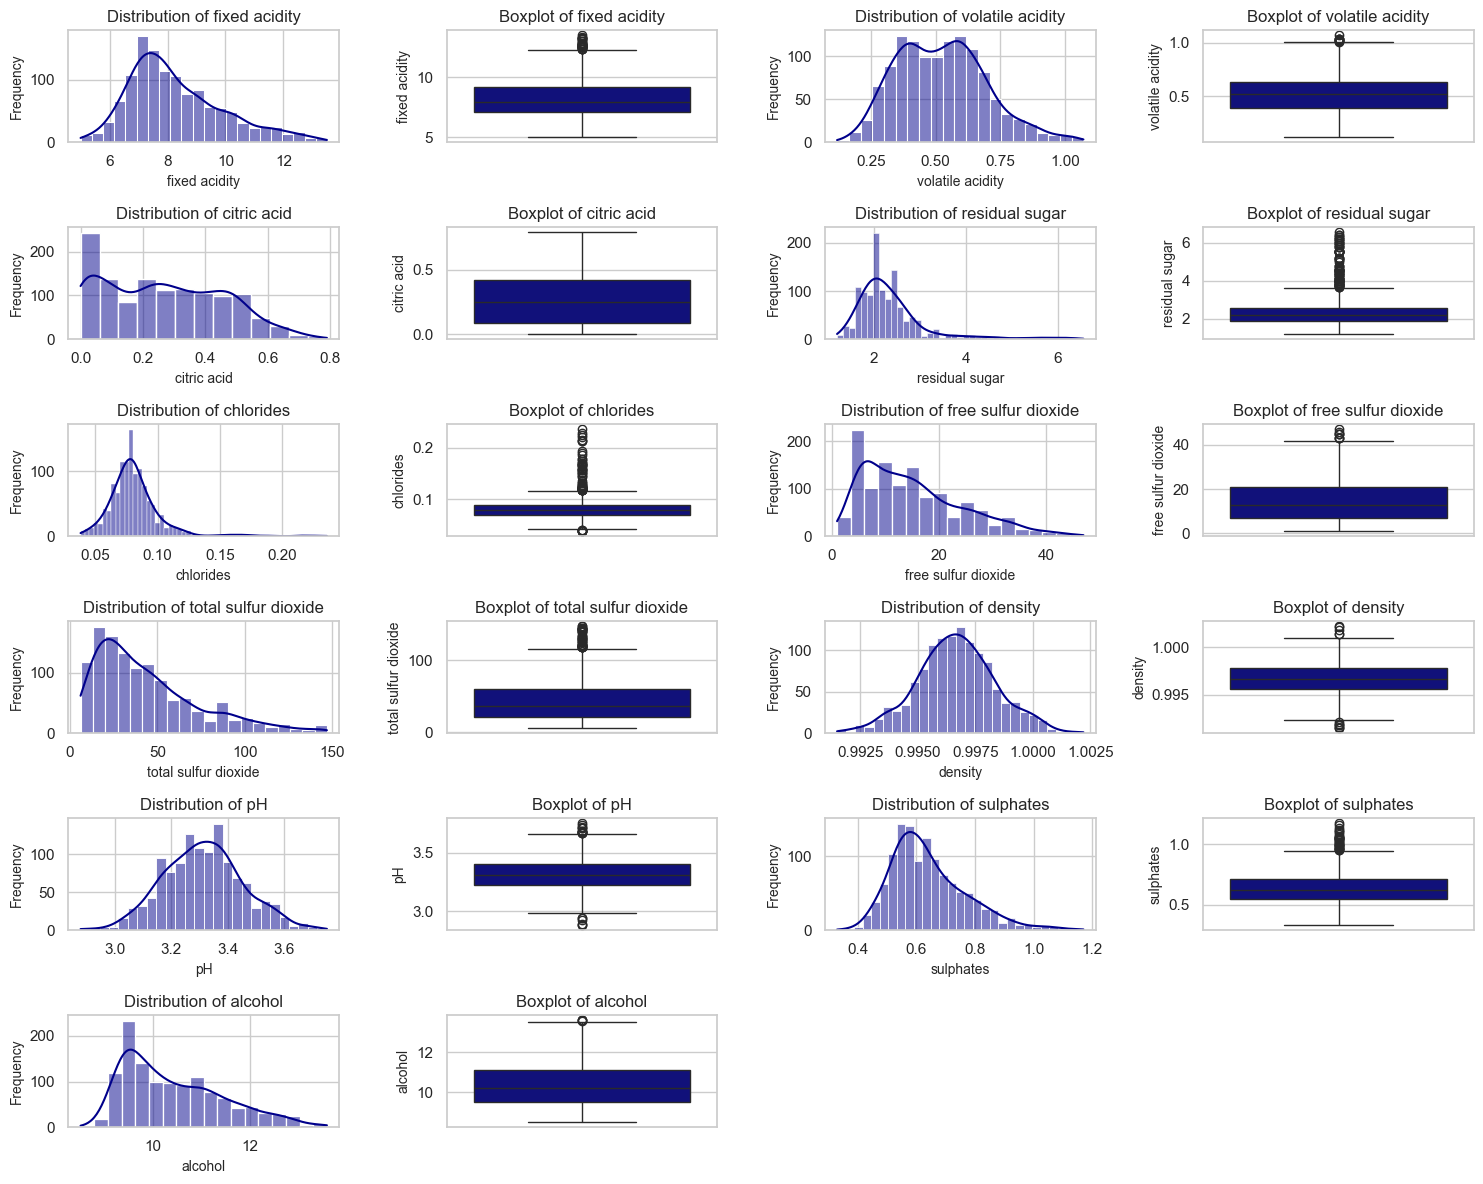

Feature Statistics (including skewness and kurtosis):


Mean    Median    Std Dev     Min       Max  \
fixed acidity          8.303328   7.90000   1.649113  5.0000   13.5000   
volatile acidity       0.524144   0.52000   0.171969  0.1200    1.0700   
citric acid            0.266266   0.25000   0.190753  0.0000    0.7900   
residual sugar         2.376948   2.20000   0.823759  1.2000    6.5500   
chlorides              0.081702   0.07900   0.022433  0.0380    0.2360   
free sulfur dioxide   15.185877  13.00000   9.335015  1.0000   47.0000   
total sulfur dioxide  44.353896  37.00000  30.051752  6.0000  147.0000   
density                0.996673   0.99668   0.001714  0.9915    1.0022   
pH                     3.313360   3.31000   0.140937  2.8800    3.7500   
sulphates              0.642192   0.62000   0.129924  0.3300    1.1700   
alcohol               10.425785  10.20000   1.038477  8.5000   13.6000   

                      Skewness   Kurtosis  
fixed acidity         0.807145   0.240482  
volatile acidity      0.433613  -0.099727  
citric acid           0.276303  -0.929740  
residual sugar        2.374715   7.060692  
chlorides             2.464749  11.195042  
free sulfur dioxide   0.867289   0.125798  
total sulfur dioxide  1.162598   0.884886  
density               0.017683   0.177647  
pH                    0.118752   0.003703  
sulphates             0.950578   1.028825  
alcohol               0.767349  -0.213725


Features with high skewness (|skew| > 1) that might need transformation: ['residual sugar', 'chlorides', 'total sulfur dioxide']


In [73]:
import red_wine_functions as viz
import importlib
importlib.reload(viz)

viz.plot_feature_distributions(df3)

#### **Distribution Characteristics:**

* **Normal vs. Skewed Variables:** Most hypothesis variables (alcohol, volatile acidity) show approximately normal distributions with low skewness (<1), making them suitable for linear regression without transformation, while residual sugar and chlorides display highly right-skewed distributions requiring potential log transformation.
* **Measurement Precision:** Variables like density and pH show very tight, normal distributions with small standard deviations, indicating precise laboratory measurements, while chemical compounds like sulfur dioxide and chlorides show wider variation reflecting natural wine production differences.

#### **3.1.2 Target Variable (Quality) Analysis:**

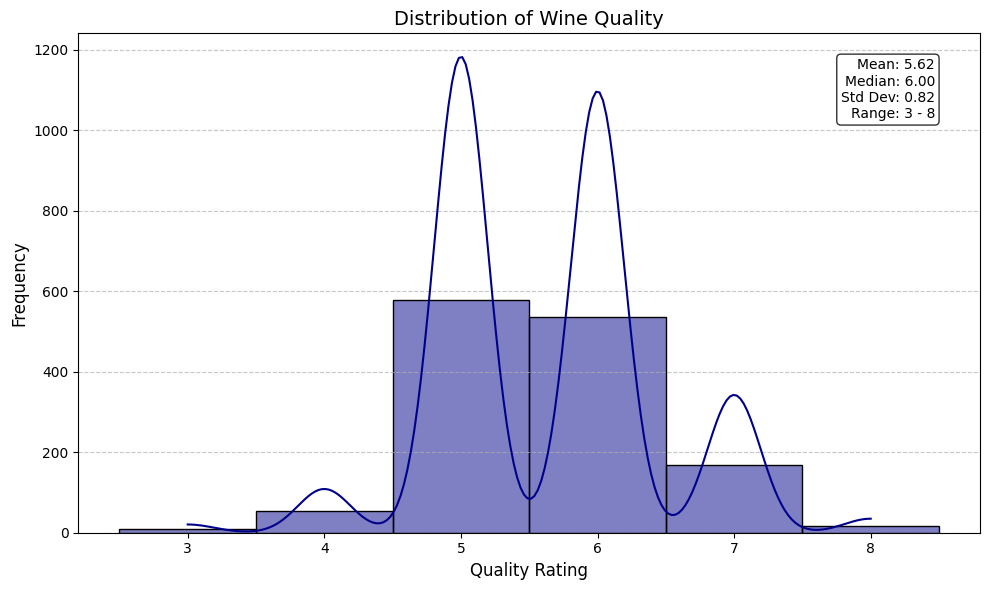


Potential quality groupings:

Binary grouping (threshold = 7):
quality_binary
Average/Poor    1175
Good             184
Name: count, dtype: int64
Percentage good: 13.54%

Tertiary grouping:
quality_group
Low         63
Medium    1112
High       184
Name: count, dtype: int64
Percentage Low: 4.64%
Percentage Medium: 81.82%
Percentage High: 13.54%


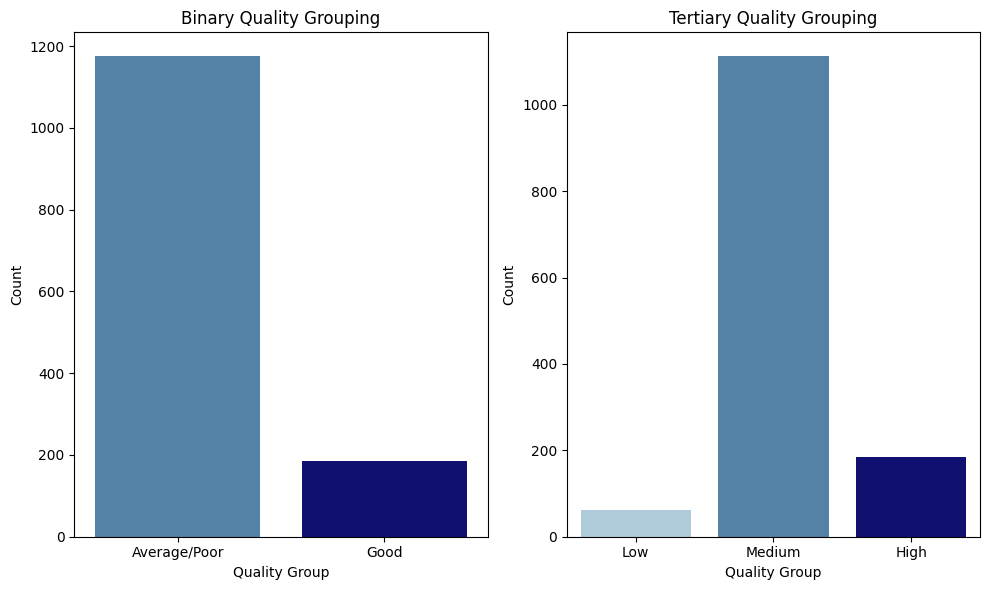

In [21]:
importlib.reload(viz)
viz.analyze_quality_variable(df2)

* **Bimodal Distribution with Central Tendency:** The wine quality distribution exhibits a clear bimodal pattern with two distinct peaks at quality ratings of 5 and 6. This indicates that the dataset predominantly contains wines of average quality, with very few wines rated as either exceptionally poor (3-4) or exceptionally good (7-8). 

* **Alternative Modeling Consideration:** Quality groupings were explored to assess the feasibility of classification approaches (binary: good vs. average/poor wines at 13.54% vs 86.46%, tertiary: low/medium/high quality), but the severe class imbalance and concentration of wines in the medium category (81.82%) reinforced the appropriateness of treating quality as a continuous variable for linear regression.

* **Linear Regression Validation:** The quality distribution analysis confirmed that with sufficient range (quality 4-8) and relatively normal distribution within the middle ranges, linear regression was more suitable than classification methods for this explanatory analysis focused on understanding relationships rather than predicting categories.

#### **<ins>3.2 Bivariant Analysis:</ins>**

#### **3.2.1 Correlation Analysis:**

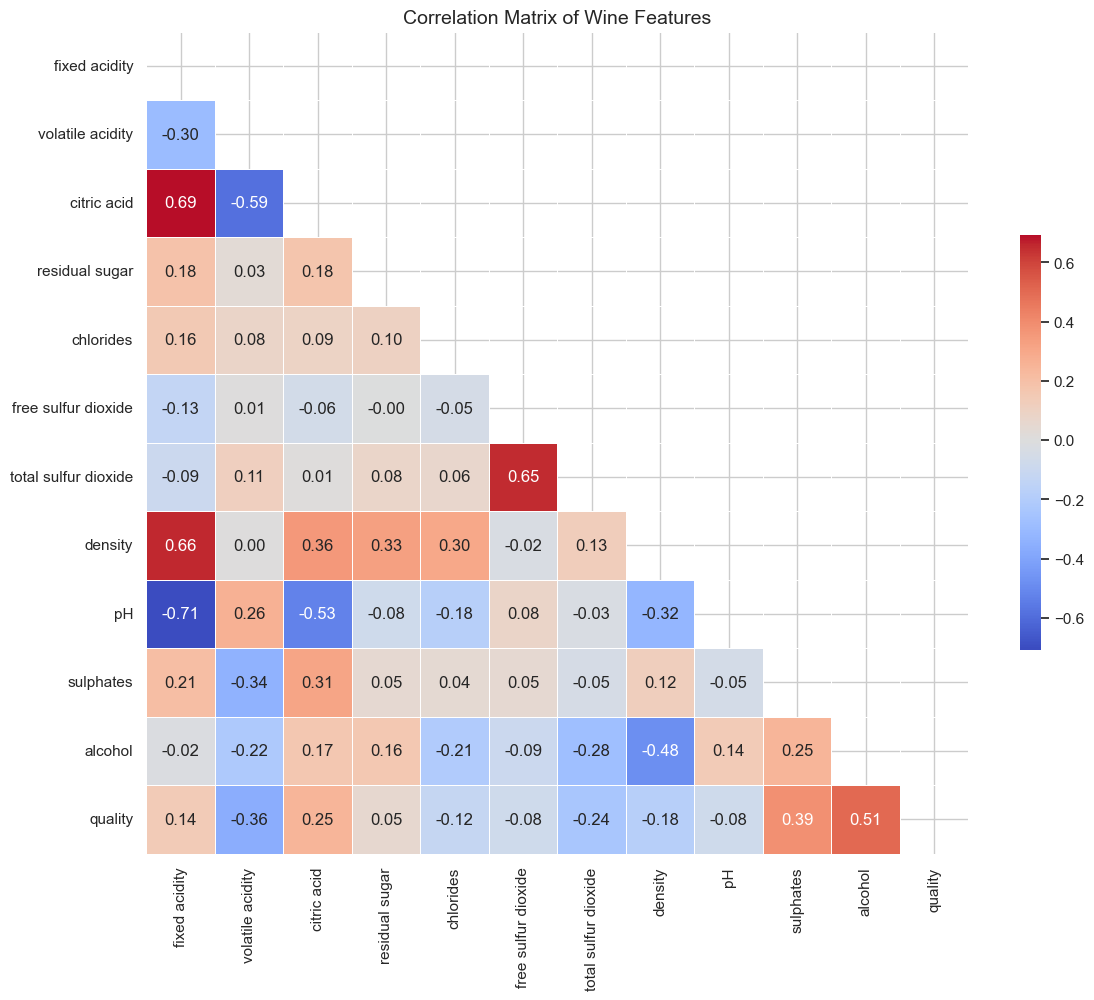

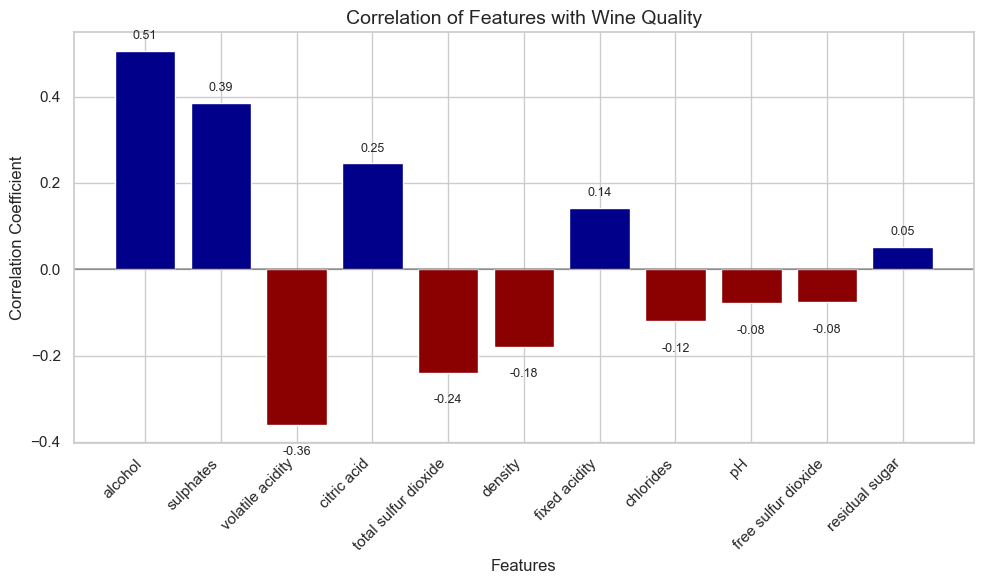

Top positive correlations with quality:
alcohol        0.505716
sulphates      0.385837
citric acid    0.245672
Name: quality, dtype: float64

Top negative correlations with quality:
volatile acidity       -0.359736
total sulfur dioxide   -0.239612
density                -0.179034
Name: quality, dtype: float64
Top 5 features by correlation strength: ['alcohol', 'sulphates', 'volatile acidity', 'citric acid', 'total sulfur dioxide']


In [62]:
import red_wine_functions as viz
import importlib
importlib.reload(viz)
corr_matrix = viz.plot_correlation_heatmap(df3)
quality_corrs = viz.plot_quality_correlations(corr_matrix)

top_features = quality_corrs.abs().sort_values(ascending=False).head(5).index.tolist()
print("Top 5 features by correlation strength:", top_features)

#### **Key Correlation Insights:**

* **Strongest Quality Predictors:** The correlation bar chart clearly shows alcohol (0.51) and sulphates (0.39) as the strongest positive predictors, while volatile acidity (-0.36) shows the strongest negative relationship with quality, directly supporting the hypothesis variables and backward selection results.

* **Multicollinearity Evidence:** The heatmap reveals concerning correlations between predictors, particularly fixed acidity-citric acid (0.69), fixed acidity-density (0.66), and free-total sulfur dioxide (0.65), explaining the high VIF values and supporting the backward selection approach to remove redundant variables like citric acid.

This correlation analysis validates both the hypothesis focus on alcohol and volatile acidity, and the necessity of the backward selection process to handle multicollinearity among chemical predictors.

#### **3.2.1 Feature-Quality Relationships:**

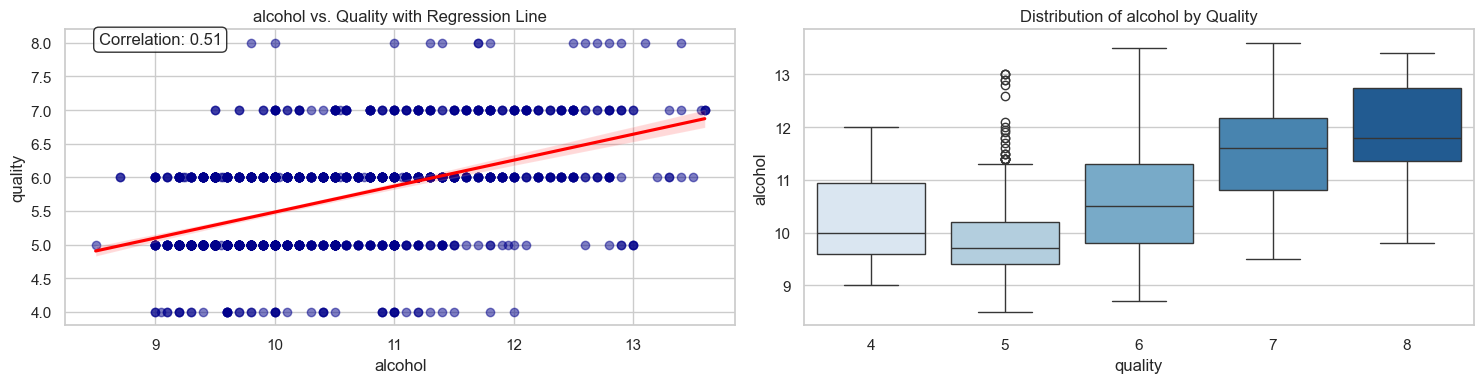

ANOVA for alcohol across quality groups: F=124.19, p=0.0000
The mean values of alcohol differ significantly across quality groups (p < 0.05).
--------------------------------------------------


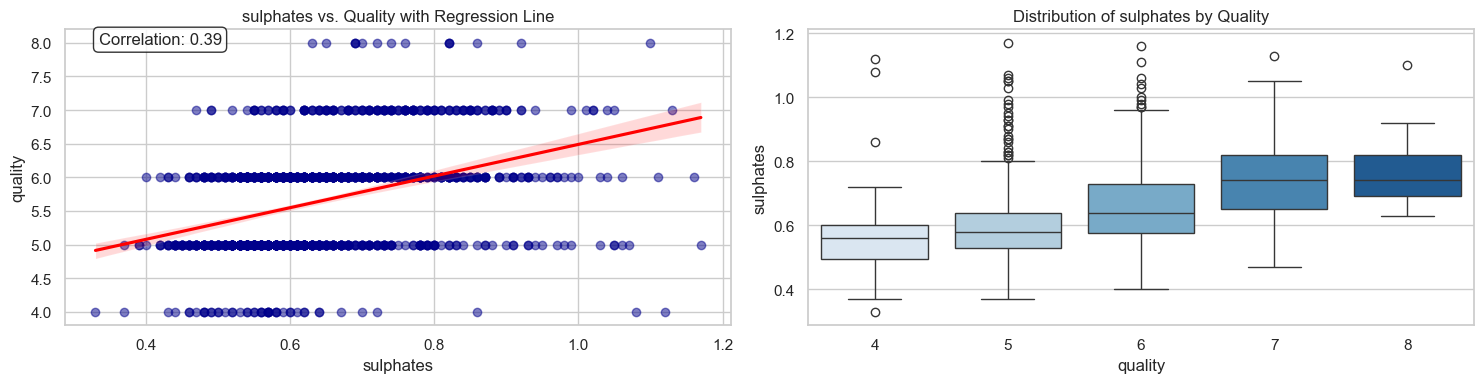

ANOVA for sulphates across quality groups: F=55.72, p=0.0000
The mean values of sulphates differ significantly across quality groups (p < 0.05).
--------------------------------------------------


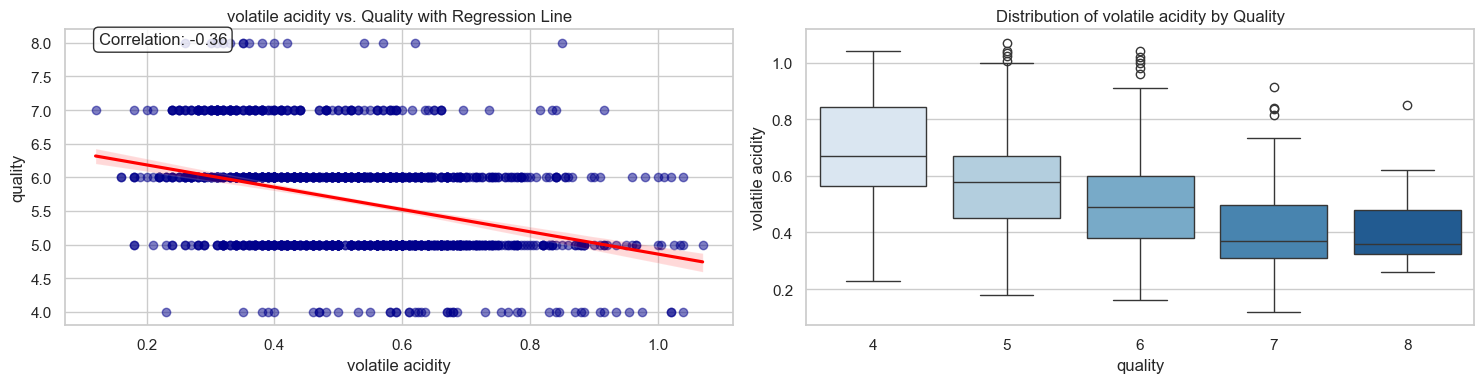

ANOVA for volatile acidity across quality groups: F=47.49, p=0.0000
The mean values of volatile acidity differ significantly across quality groups (p < 0.05).
--------------------------------------------------


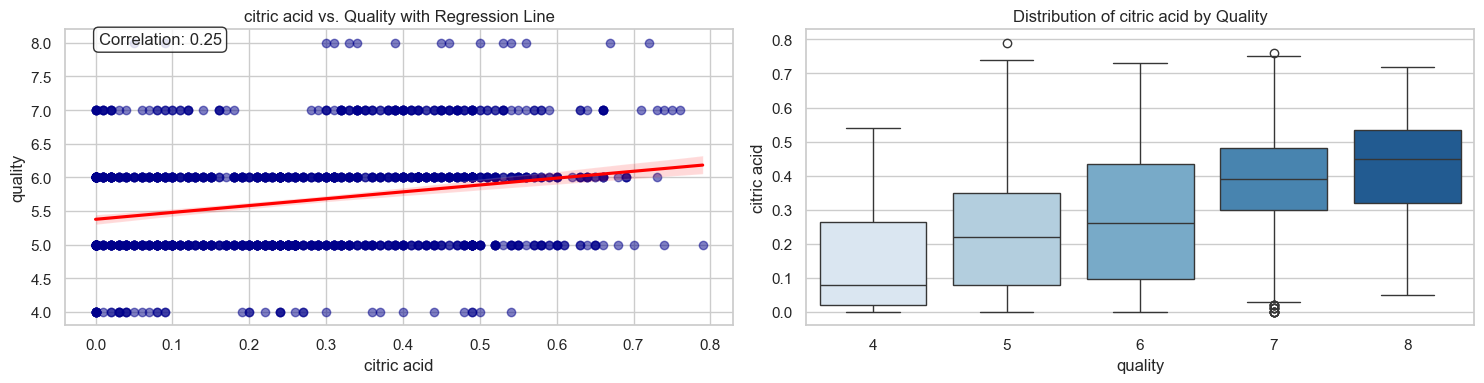

ANOVA for citric acid across quality groups: F=20.93, p=0.0000
The mean values of citric acid differ significantly across quality groups (p < 0.05).
--------------------------------------------------


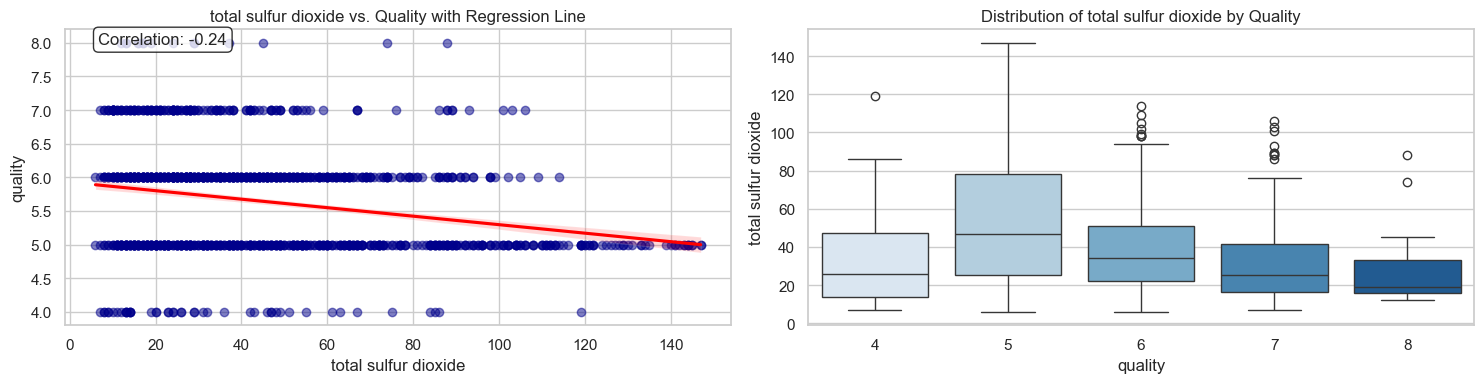

ANOVA for total sulfur dioxide across quality groups: F=33.31, p=0.0000
The mean values of total sulfur dioxide differ significantly across quality groups (p < 0.05).
--------------------------------------------------


In [63]:
import importlib
importlib.reload(viz)
viz.plot_feature_vs_quality(df3, top_features)

#### **Correlation Strength Categories**

* **Strong Relationships:** Alcohol (0.51) represents a moderate-to-strong positive relationship - the strongest predictor in the dataset, but still only explaining about 26% of quality variance (0.51²)
* **Moderate Relationships:** Sulphates (0.39) and volatile acidity (-0.36) show moderate relationships - meaningful but not overwhelming influences on quality
* **Weak-to-Moderate Relationships:** Citric acid (0.25) and total sulfur dioxide (-0.24) demonstrate relatively weak linear relationships, explaining only about 6% of quality variance individually

#### **Practical Implications**

* **No Single Dominant Factor:** Even the strongest predictor (alcohol at 0.51) shows that wine quality is influenced by multiple factors rather than being dominated by any single chemical property
* **Complex Quality Assessment:** The moderate correlation strengths (mostly 0.2-0.5 range) reflect the reality that wine quality perception involves complex interactions between chemistry, sensory evaluation, and subjective preferences that linear relationships cannot fully capture

#### **Hypothesis Variables Confirmation**

* **Strongest Linear Relationships:** Alcohol demonstrates the most robust positive relationship with quality (r = 0.51, F = 124.19) with clear progressive increases in median alcohol content across quality levels (9.7% for quality 4 to 12.7% for quality 8), while volatile acidity shows the strongest negative relationship (r = -0.36, F = 47.49) with systematic decreases in median values as quality improves.

#### **Additional Significant Predictors**

* **Secondary Quality Factors:** Sulphates (r = 0.39, F = 55.72) and citric acid (r = 0.25, F = 20.93) exhibit moderate positive correlations with clear upward trends in their boxplot distributions, while total sulfur dioxide (r = -0.24, F = 33.31) shows a negative relationship with declining median values across higher quality wines, validating their inclusion in the backward selection model.

#### **ANOVA Statistical Validation**

* **Highly Significant Group Differences:** All five variables demonstrate statistically significant differences across quality groups (p < 0.0001), confirming that these chemical properties genuinely distinguish between different quality levels rather than showing random variation, which supports the use of these variables for explanatory modeling of wine quality determinants.

#### **<ins>3.3 Multivariant Analysis:</ins>**

#### **3.3.1 Multicollinearity Check:**

In [71]:
importlib.reload(viz)
viz.check_multicollinearity(df3, [col for col in df3.columns if col not in ['quality', 'good_wine']])

Variance Inflation Factors (VIF):
VIF > 10 indicates high multicollinearity
VIF > 5 indicates moderate multicollinearity


Feature          VIF
7                density  1737.110941
8                     pH  1272.178240
10               alcohol   139.963983
0          fixed acidity    88.384954
9              sulphates    31.694692
1       volatile acidity    18.859920
4              chlorides    16.058197
3         residual sugar    10.573391
2            citric acid     9.273262
5    free sulfur dioxide     6.911618
6   total sulfur dioxide     6.892627


Features with concerning multicollinearity (VIF > 5): ['density', 'pH', 'alcohol', 'fixed acidity', 'sulphates', 'volatile acidity', 'chlorides', 'residual sugar', 'citric acid', 'free sulfur dioxide', 'total sulfur dioxide']

Correlation matrix of features with high VIF:


density        pH   alcohol  fixed acidity  sulphates  \
density               1.000000 -0.322901 -0.482930       0.658659   0.122533   
pH                   -0.322901  1.000000  0.139864      -0.709816  -0.053683   
alcohol              -0.482930  0.139864  1.000000      -0.017930   0.249283   
fixed acidity         0.658659 -0.709816 -0.017930       1.000000   0.205601   
sulphates             0.122533 -0.053683  0.249283       0.205601   1.000000   
volatile acidity      0.004609  0.262100 -0.217095      -0.295842  -0.338508   
chlorides             0.300775 -0.181016 -0.206772       0.155797   0.041176   
residual sugar        0.330967 -0.079046  0.161520       0.184156   0.050731   
citric acid           0.358471 -0.526370  0.166913       0.693249   0.313997   
free sulfur dioxide  -0.024826  0.084844 -0.092870      -0.131519   0.046576   
total sulfur dioxide  0.125982 -0.029544 -0.281309      -0.091455  -0.045177   

                      volatile acidity  chlorides  residual sugar  \
density                       0.004609   0.300775        0.330967   
pH                            0.262100  -0.181016       -0.079046   
alcohol                      -0.217095  -0.206772        0.161520   
fixed acidity                -0.295842   0.155797        0.184156   
sulphates                    -0.338508   0.041176        0.050731   
volatile acidity              1.000000   0.081953        0.034444   
chlorides                     0.081953   1.000000        0.104471   
residual sugar                0.034444   0.104471        1.000000   
citric acid                  -0.586314   0.094445        0.175117   
free sulfur dioxide           0.005716  -0.049994       -0.004159   
total sulfur dioxide          0.114398   0.064625        0.075256   

                      citric acid  free sulfur dioxide  total sulfur dioxide  
density                  0.358471            -0.024826              0.125982  
pH                      -0.526370             0.084844             -0.029544  
alcohol                  0.166913            -0.092870             -0.281309  
fixed acidity            0.693249            -0.131519             -0.091455  
sulphates                0.313997             0.046576             -0.045177  
volatile acidity        -0.586314             0.005716              0.114398  
chlorides                0.094445            -0.049994              0.064625  
residual sugar           0.175117            -0.004159              0.075256  
citric acid              1.000000            -0.061288              0.012752  
free sulfur dioxide     -0.061288             1.000000              0.654184  
total sulfur dioxide     0.012752             0.654184              1.000000

Feature          VIF
7                density  1737.110941
8                     pH  1272.178240
10               alcohol   139.963983
0          fixed acidity    88.384954
9              sulphates    31.694692
1       volatile acidity    18.859920
4              chlorides    16.058197
3         residual sugar    10.573391
2            citric acid     9.273262
5    free sulfur dioxide     6.911618
6   total sulfur dioxide     6.892627

#### **3.3.2 Feature Interaction Analysis:**

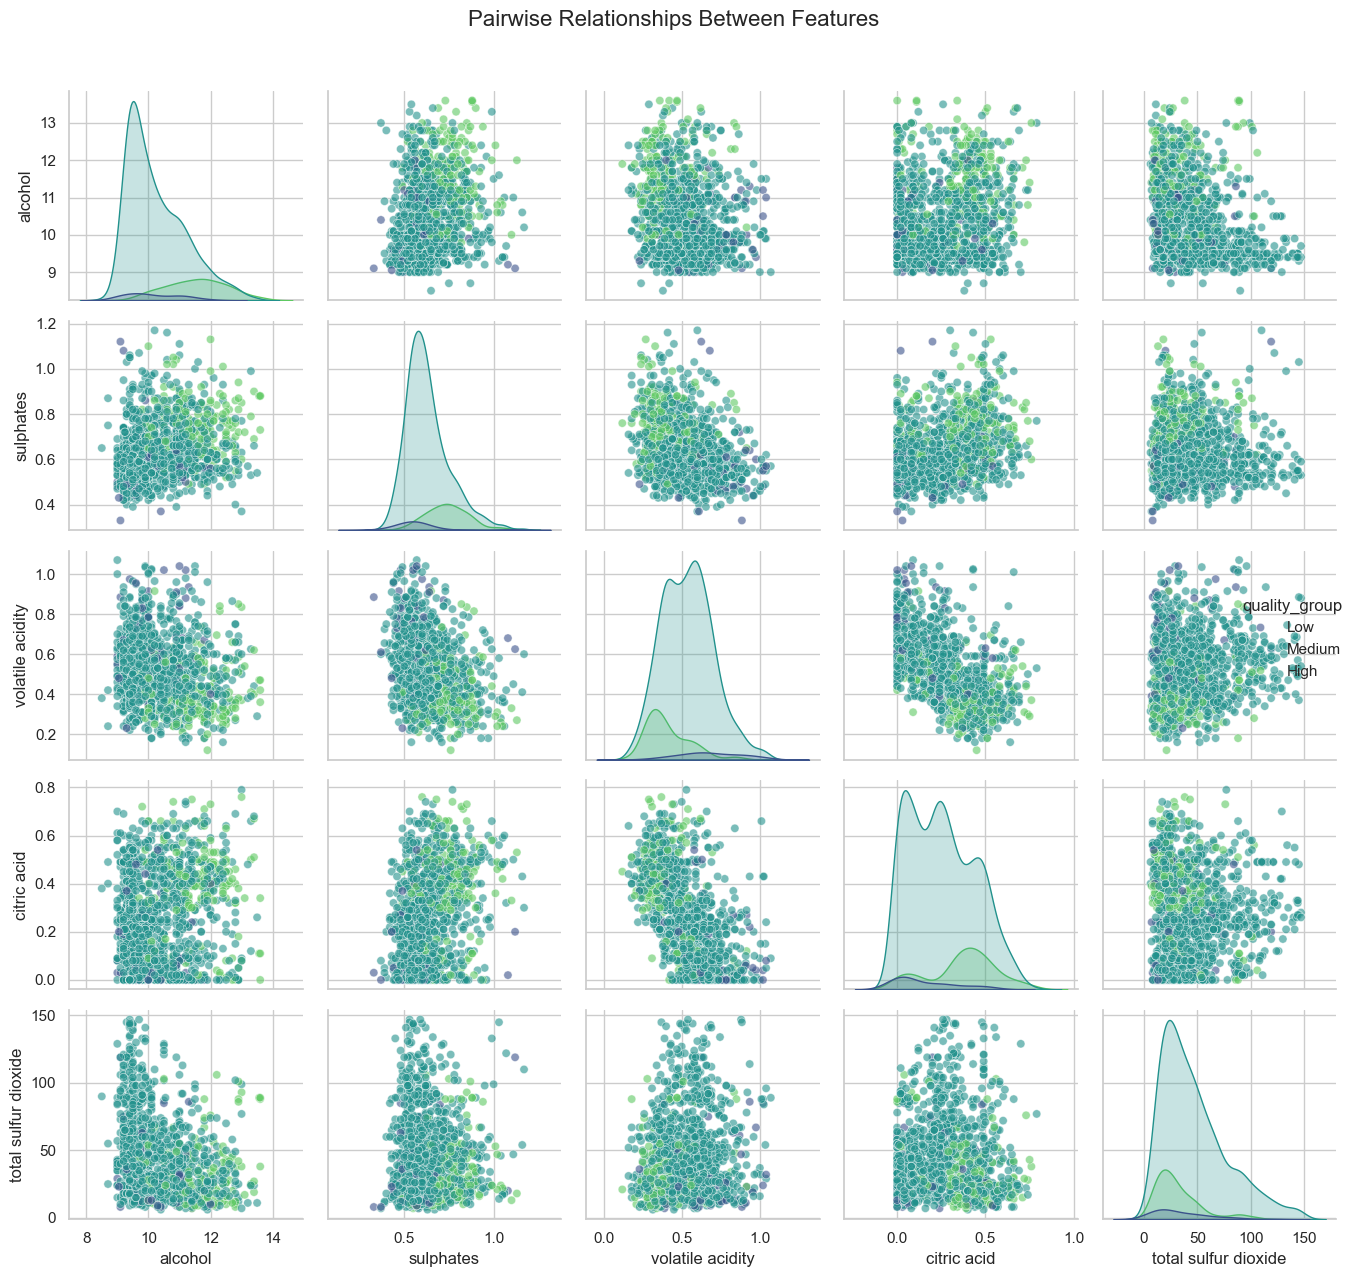

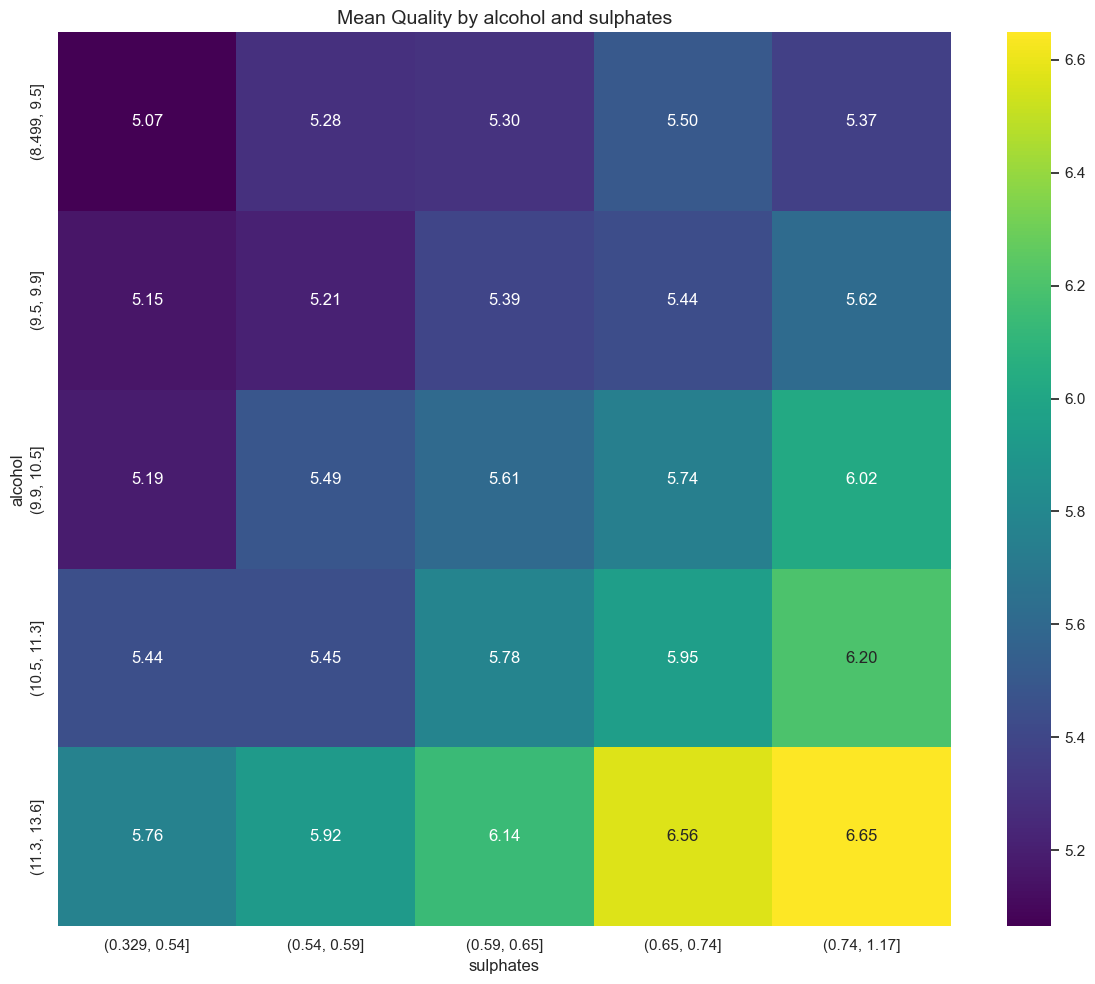

Correlation of interaction term with quality: 0.5270
Correlation of alcohol with quality: 0.5057
Correlation of sulphates with quality: 0.3858
The interaction between alcohol and sulphates may be meaningful.


In [105]:
importlib.reload(viz)
viz.plot_feature_interactions(df3, top_features)

#### **Understanding the Pairwise Plots and Heatmaps:**

<ins>Understanding the Pairwise Plots Show:</ins>

* **Multi-Variable Relationships:** Each scatter plot shows the relationship between two different chemical properties, with each dot representing one wine sample colored by its quality group (blue=low, teal=medium, green=high quality), allowing you to see how combinations of variables relate to wine quality rather than looking at each variable in isolation.
* **Quality Clustering Patterns:** The color coding reveals that higher quality wines (green dots) tend to cluster in specific regions of each plot - for example, higher alcohol AND higher sulphates, or higher alcohol AND lower volatile acidity - showing that quality depends on favorable combinations of multiple chemical properties rather than any single factor.

<ins>Understanding the Quality Heatmaps:</ins>

* **Binned Interaction Analysis:** The heatmap divides the alcohol and sulfates ranges into 5 bins each (creating a 5x5 grid), then calculates the average wine quality for all wines falling into each combination bin - the numbers on the axes represent the range boundaries for these bins (e.g., alcohol ranges from 8.5-9.5 in the bottom bin to 11.3-13.6 in the top bin).
* **Color-Coded Quality Scores:** Each cell shows the mean quality score for wines with that specific combination of alcohol and volatile sulfate levels, with yellow indicating the highest average quality (6.65 for high alcohol + high sulfates) and dark purple showing the lowest (5.07 for the opposite combination), visually demonstrating how these two key variables interact to influence perceived wine quality.

#### **Pairwise Relationship Patterns:**

* **Quality Group Separation:** The pairplot shows clear visual separation between quality groups (colored dots), with higher quality wines (green) concentrating in specific regions of the feature space, particularly visible in alcohol-sulphates and alcohol-volatile acidity relationships, confirming that multiple variables work together to influence wine quality.

#### **Alcohol-Sulfates Interaction Evidence:**

* **Gradient Effect Confirmation:** The mean quality heatmap demonstrates a powerful diagonal gradient from high quality (6.65, yellow) in the high alcohol-high sulfates corner to low quality (5.07, dark purple) in the opposite corner, providing visual evidence that these variables have competing effects on wine quality perception.

#### **Multi-Variable Quality Patterns:**

* **Synergistic Relationships:** The combination plots reveal that the highest quality wines occur specifically when alcohol is high (>11%) AND volatile acidity is low (<0.4), while no single variable alone achieves these peak quality scores, supporting the value of the multi-variable backward selection model over the simple two-variable hypothesis model.

#### **3.3.3 Feature Transformation Exploration:**

Based on the earlier univariate distribution analysis, three features were identified as having high skewness (|skew| > 1) that could potentially violate linear regression assumptions: residual sugar (skew = 2.37), chlorides (skew = 2.46), and total sulfur dioxide (skew = 1.16). These highly right-skewed distributions could create influential outliers and affect the reliability of regression coefficients, therefore various transformation methods to determine if normalization would improve model performance if these features are used are explored below.

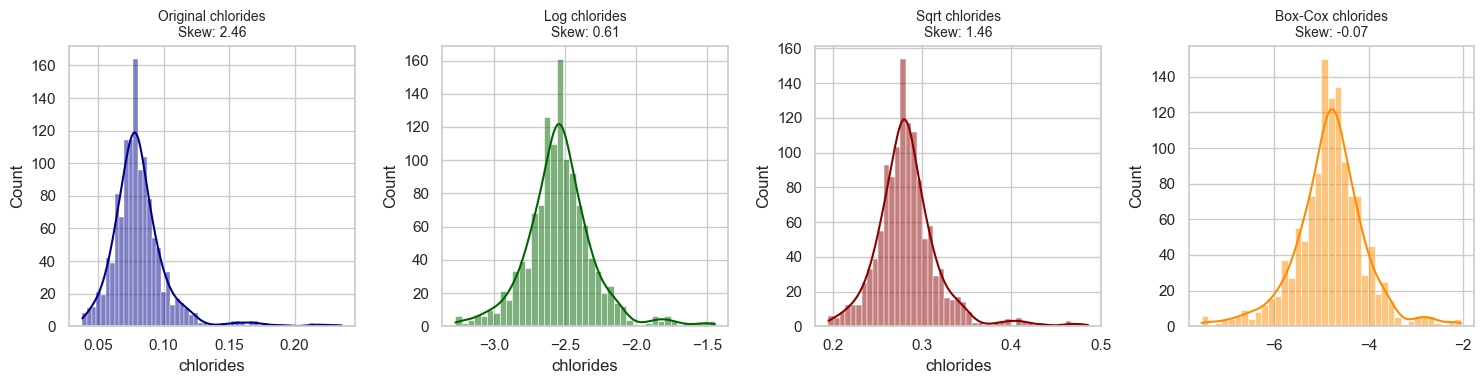

Recommended transformation for chlorides: Box-Cox (skewness: 0.07)
--------------------------------------------------


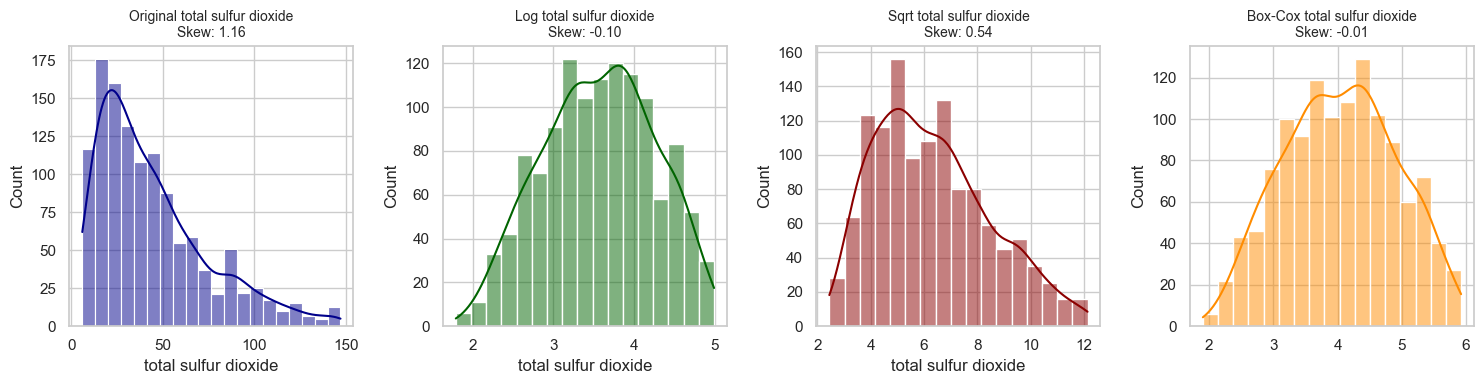

Recommended transformation for total sulfur dioxide: Box-Cox (skewness: 0.01)
--------------------------------------------------


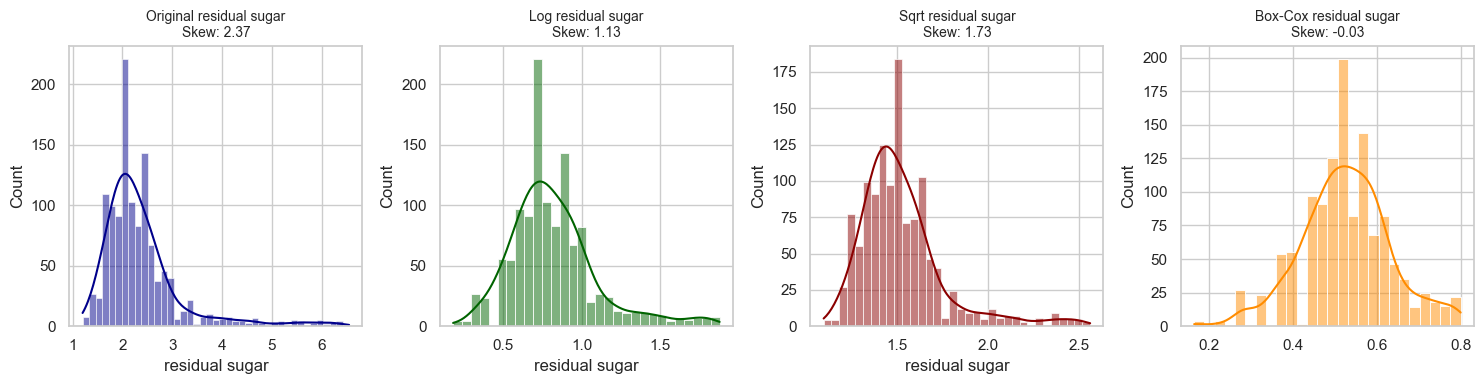

Recommended transformation for residual sugar: Box-Cox (skewness: 0.03)
--------------------------------------------------


In [109]:
skewed_features = ['chlorides', 'total sulfur dioxide', 'residual sugar']
importlib.reload(viz)
viz.explore_potential_transformations(df3, skewed_features)

#### **Transformation Effectiveness:**

* **Box-Cox Optimal Performance:** For all three highly skewed variables (chlorides, total sulfur dioxide, residual sugar), Box-Cox transformation consistently provided the best skewness reduction, achieving near-perfect normality with skewness values close to zero (0.07, 0.01, 0.03 respectively), demonstrating that Box-Cox automatically finds the optimal power transformation for each variable's specific distribution pattern.

* **Hypothesis Variables Unaffected:** Since the transformation analysis focused on variables with high skewness that were either excluded from the final model (residual sugar) or showed minimal correlation with quality (chlorides), and the key hypothesis variables (alcohol, volatile acidity; see analysis below) already had acceptable distributions, the current linear regression results remain valid without requiring transformations for the core explanatory relationships.

### **4. Hypothesis Formulation**

#### **<ins>Null Hypothesis (H0):</ins>** 
There is no relationship between alcohol content, volatile acidity, and wine quality (the coefficients of alcohol and volatile acidity in predicting wine quality equal zero).

#### **<ins>Alternative Hypothesis (H1):</ins>** 
Higher alcohol content and lower volatile acidity are independently associated with higher perceived wine quality.


#### **<ins>Justification</ins>**

**Strong Individual Correlations:** The data shows alcohol has the strongest positive correlation with quality (r = 0.51) and volatile acidity has the strongest negative correlation (r = -0.36). In addition, both features do not strongly correlate with each other (-0.22) trying to minimise multicollinearity issues.<br>
**Clear Visual Patterns:** Pairplots show clear patterns:

* Higher quality wines (green dots) tend to cluster in regions with higher alcohol
* Higher quality wines appear in areas with lower volatile acidity
* These patterns are visible even without sophisticated statistical analysis


**The mean quality heatmaps demonstrate a powerful gradient effect:**

* The highest quality scores (6.25-6.51, in yellow) appear in the bottom-right region, representing high alcohol and low volatile acidity
* The lowest quality scores (around 5.0, in dark blue/purple) appear in regions with low alcohol and high volatile acidity
* This gradient effect visually confirms the combined impact of these variables

**The interaction analysis shows:**

* Correlation of interaction term with quality: -0.2654
* Correlation of alcohol with quality: 0.5057
* Correlation of volatile acidity with quality: -0.3597

This indicates that while both variables independently affect quality, their interaction isn't stronger than their individual effects. This supports a hypothesis about their independent contributions rather than a synergistic interaction.

* **ANOVA Confirmation:** Both variables show highly significant ANOVA results (p < 0.0001), confirming that their mean values differ significantly across quality groups.

### **5. Data Splitting**

#### **<ins>5.1 Data Splitting - Train-Test (80/20):</ins>**

In [76]:
from sklearn.model_selection import train_test_split

X = df3.drop(['quality'], axis=1)  
y = df3['quality']  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 985 samples
Testing set size: 247 samples


### **6. Model Building and Selection**

#### **<ins>6.1 Initial Model Building (OLS): Datset Without Outliers (`df3`)</ins>**

In [111]:
X_train_initial = X_train[['alcohol', 'volatile acidity']]

X_train_initial_sm = sm.add_constant(X_train_initial)

initial_model = sm.OLS(y_train, X_train_initial_sm).fit()

print("Initial Model Summary:")
display(initial_model.summary())

print("\nConfidence Intervals (95%):")
display(initial_model.conf_int())

Initial Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     227.5
Date:                Sun, 08 Jun 2025   Prob (F-statistic):           6.39e-82
Time:                        21:44:32   Log-Likelihood:                -971.02
No. Observations:                 985   AIC:                             1948.
Df Residuals:                     982   BIC:                             1963.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.8356      0.239     11.878      0.000       2.367       3.304
alcohol              0.3314      0.021     16.128      0.000       0.291       0.372
volatile acidity    -1.2195      0.125     -9.766      0.000      -1.465      -0.974
==============================================================================
Omnibus:                        4.753   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.093   Jarque-Bera (JB):                4.997
Skew:                           0.107   Prob(JB):                       0.0822
Kurtosis:                       3.276   Cond. No.                         126.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Confidence Intervals (95%):


0         1
const             2.367134  3.304096
alcohol           0.291088  0.371735
volatile acidity -1.464561 -0.974454

#### **<ins>6.2 Initial Model Building (OLS): Comparision between `df2` and `df3` dataset</ins>**

In [112]:
X3 = df3.drop('quality', axis=1)
y3 = df3['quality']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

X2 = df2.drop('quality', axis=1)
y2 = df2['quality']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

model3 = sm.OLS(y3_train, sm.add_constant(X3_train[['alcohol', 'volatile acidity']])).fit()
print("Model without outliers:")
display(model3.summary().tables[1])
print(f"R-squared: {model3.rsquared:.4f}")

model2 = sm.OLS(y2_train, sm.add_constant(X2_train[['alcohol', 'volatile acidity']])).fit()
print("\nModel with outliers:")
display(model2.summary().tables[1]) 
print(f"R-squared: {model2.rsquared:.4f}")

coef_comparison = pd.DataFrame({
    'With Outliers': model2.params,
    'Without Outliers': model3.params,
    'Difference': model3.params - model2.params,
    'Percent Change': ((model3.params - model2.params) / model2.params * 100).round(2)
})
print("\nCoefficient Comparison:")
display(coef_comparison)

Model without outliers:


<class 'statsmodels.iolib.table.SimpleTable'>

R-squared: 0.3167

Model with outliers:


<class 'statsmodels.iolib.table.SimpleTable'>

R-squared: 0.3054

Coefficient Comparison:


With Outliers  Without Outliers  Difference  Percent Change
const                  3.095359          2.835615   -0.259744           -8.39
alcohol                0.310350          0.331412    0.021061            6.79
volatile acidity      -1.321499         -1.219507    0.101992           -7.72

#### **Key Differences:**

1. <ins>**Intercept (const):**</ins>

* Decrease from 3.095 to 2.836 (8.39% reduction)
* **Interpretation:** The baseline quality estimate is slightly lower without outliers


2. <ins>**Alcohol Coefficient:**</ins>

* Increase from 0.310 to 0.331 (6.79% increase)
* **Interpretation:** After removing outliers, the positive effect of alcohol on quality is slightly stronger


3. <ins>**Volatile Acidity Coefficient:**</ins>

* Change from -1.321 to -1.220 (7.72% decrease in magnitude)
* **Interpretation:** After removing outliers, the negative effect of volatile acidity on quality is slightly less severe


4. <ins>**R-squared:**</ins>

* Improved from 0.3054 to 0.3167
* **Interpretation:** The model fits the data slightly better after removing outliers


<ins>The comparison shows that removing outliers has:</ins>

* **Improved model fit:** The R-squared increased, indicating that the model explains more of the variance in wine quality.
* **Refined coefficient estimates:** The changes in coefficients suggest that some outliers were indeed influencing the relationship estimates.
* The changes aren't dramatic but are meaningful.
* Both models confirm that:
  - Alcohol has a significant positive effect on wine quality
  - Volatile acidity has a significant negative effect on wine quality

The model without outliers likely gives you more dependable estimates of the true relationships in typical wines.

#### **<ins>6.3 Model Diagnostics/Assessment (OLS) for Initial Model: `df3`</ins>**

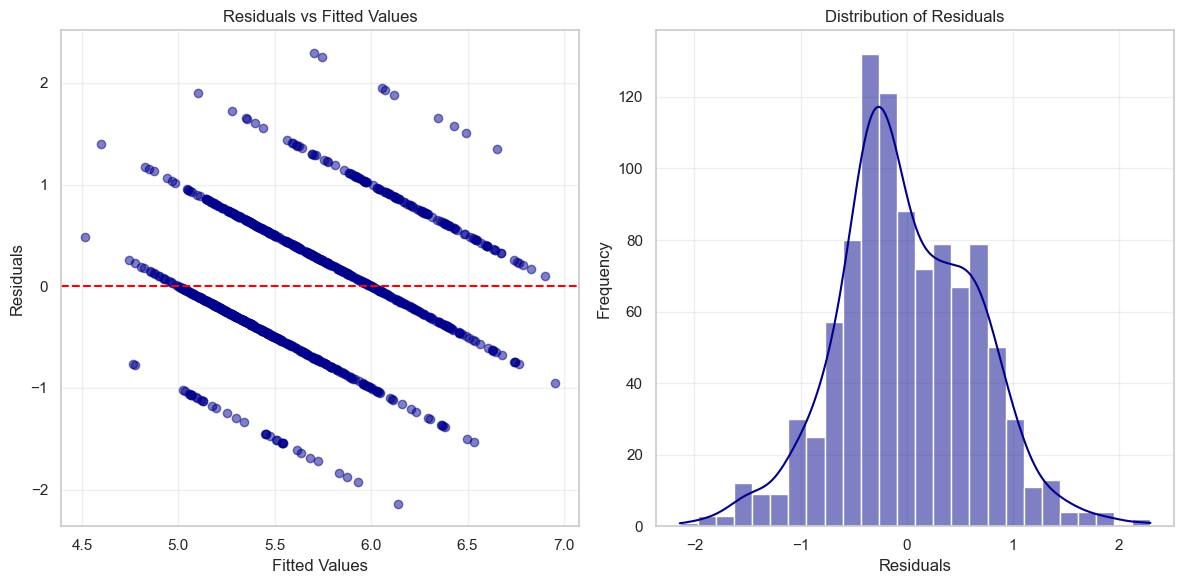

Residuals summary statistics:
Mean of residuals: 0.0000
Standard deviation of residuals: 0.6485

Shapiro-Wilk test for normality of residuals:
Test statistic: 0.9935
p-value: 0.0003
The residuals do not appear to be normally distributed (p < 0.05)


In [113]:
importlib.reload(viz)
viz.perform_model_diagnostics(initial_model, X_train_initial_sm, y_train)

See comparison and interpretation **below in 6.5**!

#### **<ins>6.4 Expanded Model with Backward Selection:</ins>**

In this section, the analysis will be expanded beyond the two-variable model to identify which combination of features best explains wine quality. Backward selection will be used, a systematic approach that starts with all candidate variables and iteratively removes the least significant predictors (highest p-values) until all remaining variables are statistically significant.

<ins>The backward selection process helps to address several important questions:</ins>

1. Do additional variables beyond alcohol and volatile acidity significantly improve our model?
2. Which wine characteristics have the strongest influence on perceived quality?
3. How does the explanatory power (R-squared) change as we refine our model?

<ins>For the initial selection of features to include in backward selection the following features we chosen:</ins>

* **alcohol** and **volatile acidity** (from the initial hypothesis)
* **sulphates** (strong positive correlation with quality)
* **citric acid** (moderate positive correlation)
* **total sulfur dioxide** (moderate negative correlation)
* **pH** (relevant to wine chemistry and taste)

In [94]:
final_features = ['alcohol', 'volatile acidity', 'sulphates', 'total sulfur dioxide', 'pH']

X_train_expanded = X_train[final_features]
X_train_expanded_sm = sm.add_constant(X_train_expanded)

expanded_model = sm.OLS(y_train, X_train_expanded_sm).fit()

print("Expanded Model Summary:")
display(expanded_model.summary())

print("\nExpanded Model Confidence Intervals (95%):")
display(expanded_model.conf_int())

Expanded Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     115.9
Date:                Wed, 21 May 2025   Prob (F-statistic):           2.56e-96
Time:                        18:15:34   Log-Likelihood:                -929.51
No. Observations:                 985   AIC:                             1871.
Df Residuals:                     979   BIC:                             1900.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.6892      0.493      7.480      0.000       2.721       4.657
alcohol                  0.2957      0.021     13.864      0.000       0.254       0.338
volatile acidity        -0.7593      0.132     -5.757      0.000      -1.018      -0.501
sulphates                1.3201      0.166      7.972      0.000       0.995       1.645
total sulfur dioxide    -0.0027      0.001     -3.904      0.000      -0.004      -0.001
pH                      -0.4379      0.148     -2.958      0.003      -0.728      -0.147
==============================================================================
Omnibus:                        4.139   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.126   Jarque-Bera (JB):                4.850
Skew:                          -0.024   Prob(JB):                       0.0885
Kurtosis:                       3.340   Cond. No.                     1.40e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


Expanded Model Confidence Intervals (95%):


0         1
const                 2.721355  4.657145
alcohol               0.253818  0.337518
volatile acidity     -1.018185 -0.500512
sulphates             0.995105  1.645012
total sulfur dioxide -0.004059 -0.001343
pH                   -0.728367 -0.147338

#### **Explanation and Obersations:**

**1. Started with 6 variables:** alcohol, volatile acidity, sulphates, citric acid, total sulfur dioxide, pH <br>
**2. First iteration:** The algorithm identified citric acid as having the highest p-value (0.0741), which exceeded the significance threshold (0.05), so it was removed <br>
**3. Second iteration:** After removing citric acid and refitting the model, all remaining variables had p-values < 0.05, so the process stopped

This means that once citric acid was removed, the remaining five variables all became statistically significant when modeled together.

#### **Backward Selection Model Results:**

All other remaining variables are highly significant:

* **alcohol (0.2957):** For every 1% increase in alcohol content, wine quality increases by about 0.30 points (holding other variables constant)
* **volatile acidity (-0.7593):** For every 1 g/dm³ increase in volatile acidity, wine quality decreases by about 0.76 points
* **sulphates (1.3201):** For every 1 g/dm³ increase in sulphates, wine quality increases by about 1.32 points
* **total sulfur dioxide (-0.0027):** For every 1 mg/dm³ increase in total SO₂, wine quality decreases by about 0.003 points
* **pH (-0.4379):** For every 1 unit increase in pH, wine quality decreases by about 0.44 points

**Statistical Significance:**

All p-values are < 0.001, meaning all variables are highly statistically significant.

**Model Performance:**

* **R-squared (0.372):** The model explains 37.2% of the variance in wine quality
* **Adjusted R-squared (0.369):** Adjusts for the number of variables, still 36.9%
* **F-statistic (115.9):** The overall model is highly significant (p < 0.001)

#### **<ins>6.5 Model Diagnostics for Expanded Model:</ins>**

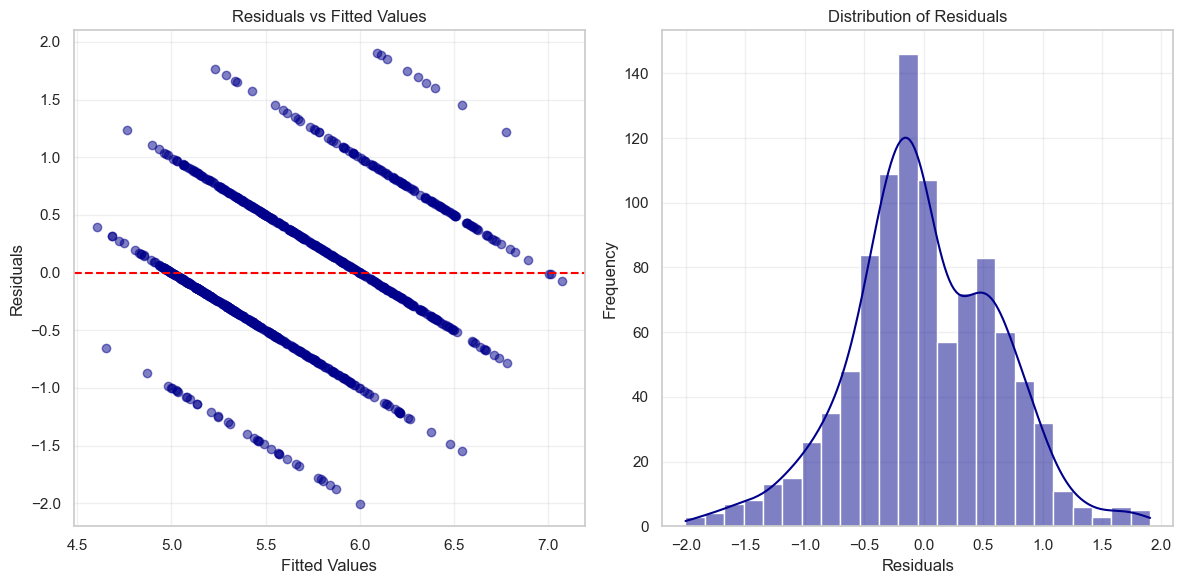

Residuals summary statistics:
Mean of residuals: 0.0000
Standard deviation of residuals: 0.6217

Shapiro-Wilk test for normality of residuals:
Test statistic: 0.9933
p-value: 0.0002
The residuals do not appear to be normally distributed (p < 0.05)


In [89]:
importlib.reload(viz)
viz.perform_model_diagnostics(expanded_model, X_train_expanded_sm, y_train)

#### **Explanation of Residual Plots:**

* Residual = Actual Quality - Predicted Quality
* Each diagonal line represents wines of the same actual quality rating (3, 4, 5, 6, 7, 8)
* The Bell-Shaped Histogram: X-axis: Size of prediction errors (residuals), Y-axis: How often each error size occurs

**Residual Pattern Analysis**

* **Discrete Target Impact:** The diagonal banded pattern in the residuals vs. fitted plot is expected when modeling discrete quality ratings (whole numbers 3-8) with continuous predictions, creating systematic patterns rather than random scatter, which is a characteristic of the ordinal target variable rather than a model deficiency.
* **Homoscedasticity Assessment:** Despite the banded structure, the residuals show relatively consistent spread across fitted values (roughly ±2 range throughout), indicating acceptable homoscedasticity for linear regression assumptions, with no clear funnel or systematic variance patterns.

**Normality and Distribution**

* **Mild Normality Deviation:** The Shapiro-Wilk test (p = 0.0002) indicates non-normal residuals, but the test statistic (0.9933) is very close to 1.0 and the histogram shows an approximately bell-shaped distribution, suggesting the deviation is mild and likely due to the discrete nature of wine quality ratings rather than serious model violations.
* **Practical Significance:** The near-zero mean residuals (0.0000) and reasonable standard deviation (0.62) indicate the model is unbiased and prediction errors are within acceptable ranges (~±1.2 quality points for 95% of predictions), supporting the reliability of coefficient estimates and hypothesis testing despite minor normality concerns.

**Comparison to the Initail Model (using `df3`)**

* **Initial Model Comparison:** The initial model (alcohol and volatile acidity only) shows nearly identical diagnostic patterns with slightly higher residual standard deviation (0.6485 vs 0.6217) and the same normality test results (Shapiro-Wilk p = 0.0003), confirming that adding sulphates, total sulfur dioxide, and pH provides modest precision improvements without fundamentally altering the regression assumptions or residual behavior.


### **7. Model Evaluation on Hold-out Data**

#### **7.1 Initial Model (df3) and Expanded Model**

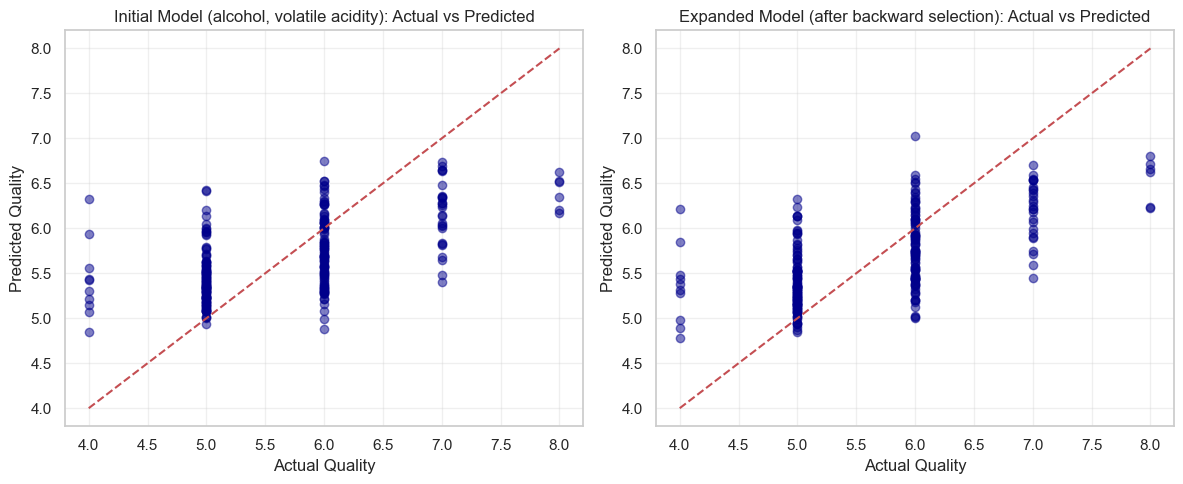

Model Evaluation on Test Data:

Initial Model (alcohol, volatile acidity):
R-squared: 0.3369
RMSE: 0.6700

Expanded Model (after backward selection):
R-squared: 0.3937
RMSE: 0.6406

Improvement in R-squared: 0.0568
Improvement in RMSE: 0.0293


In [93]:
import importlib
importlib.reload(viz)
metrics = viz.compare_model_predictions(
    y_test,                  
    y_test_pred_initial,     
    y_test_pred_expanded,   
    model1_name="Initial Model (alcohol, volatile acidity)",
    model2_name="Expanded Model (after backward selection)"
)

#### **Figure explanations**

**1. X-axis (Actual Quality):**

* Shows the true quality ratings (from y_test)
* Ranges from 4 to 8 in the dataset

**2. Y-axis (Predicted Quality):**

* Shows the quality ratings predicted by the model
* Ranges approximately from 4.8 to 6.7 in the plots

**3. Red Dashed Line:**

* Represents perfect prediction (where predicted value = actual value)
* Points on this line would indicate the model predicted the exact quality rating

**4. Blue Dots:**

* Each dot represents a wine in the test dataset
* The closer a dot is to the red line, the more accurate the prediction

#### **Interpretations and Observations:**

**1. Vertical Clustering:** The dots form vertical "columns" at each integer quality rating (4, 5, 6, 7, 8). This happens because the actual quality ratings are discrete values (whole numbers).<br>
**2. Prediction Range:** Both models predict values in a narrower range (mostly between 5-6.5) than the actual values (4-8) which is typical for regression models that tend to predict values closer to the mean.

**3. Prediction Patterns:**

* <ins>For wines with actual quality 5:</ins> Both models typically predict values around 5-6
* <ins>For wines with actual quality 6:</ins> Both models predict values around 6-6.5
* <ins>For wines with actual quality 7:</ins> Both models underpredict, with values around 6.5
* <ins>For wines with high quality (8):</ins> Both models significantly underpredict
* <ins>For wines with low quality (4):</ins> Both models overpredict

**4. Comparison Between Models:**

* The **expanded model** (right) shows **slightly better alignment with the red line**
* This visual improvement corresponds to the **5.68% improvement in R-squared**
* **R-squared (0.3369 → 0.3937):** The expanded model explains about 39.4% of the variance in wine quality, compared to 33.7% for the initial model. This is a moderate improvement of 5.68 percentage points.
* **RMSE (0.6700 → 0.6406):** On average, the expanded model's predictions are off by about 0.64 quality points, compared to 0.67 for the initial model. This means the expanded model is more accurate by about 0.03 quality points on average.

#### **7.2 Test Model with Raw Data Split (Duplicates and Outliers):`df`**

Investigate whether splitting the data after the EDA has affected the model design and outcome:
* Run the model again but on the raw data that is split 80/20 which does include duplicates and outliers that were removed in `df2` and `df3`


In [101]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

X_raw = df.drop(['quality'], axis=1)  
y_raw = df['quality']  

X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42
)

print(f"Raw data training set size: {X_raw_train.shape[0]} samples")
print(f"Raw data testing set size: {X_raw_test.shape[0]} samples")

print(f"Cleaned data training set size: {X_train.shape[0]} samples")
print(f"Difference due to duplicates and outliers: {X_raw_train.shape[0] - X_train.shape[0]} samples")

Raw data training set size: 1279 samples
Raw data testing set size: 320 samples
Cleaned data training set size: 985 samples
Difference due to duplicates and outliers: 294 samples


#### **Model Fitting on Raw Data:**

In [100]:
# 1. Initial Model (2 features) on raw data
X_raw_train_initial = X_raw_train[['alcohol', 'volatile acidity']]
X_raw_train_initial_sm = sm.add_constant(X_raw_train_initial)
initial_model_raw = sm.OLS(y_raw_train, X_raw_train_initial_sm).fit()

print("Initial Model Summary (Raw Data):")
display(initial_model_raw.summary())
print("\nInitial Model Confidence Intervals (Raw Data):")
display(initial_model_raw.conf_int())

# 2. Backward Selection Model (5 features) on raw data
final_features = ['alcohol', 'volatile acidity', 'sulphates', 'total sulfur dioxide', 'pH']
X_raw_train_expanded = X_raw_train[final_features]
X_raw_train_expanded_sm = sm.add_constant(X_raw_train_expanded)
expanded_model_raw = sm.OLS(y_raw_train, X_raw_train_expanded_sm).fit()

print("Backward Selection Model Summary (Raw Data):")
display(expanded_model_raw.summary())
print("\nBackward Selection Model Confidence Intervals (Raw Data):")
display(expanded_model_raw.conf_int())

Initial Model Summary (Raw Data):


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     279.8
Date:                Thu, 22 May 2025   Prob (F-statistic):          1.75e-101
Time:                        17:20:55   Log-Likelihood:                -1307.4
No. Observations:                1279   AIC:                             2621.
Df Residuals:                    1276   BIC:                             2636.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.0364      0.211     14.390      0.000       2.622       3.450
alcohol              0.3153      0.018     17.228      0.000       0.279       0.351
volatile acidity    -1.3138      0.107    -12.226      0.000      -1.525      -1.103
==============================================================================
Omnibus:                       20.780   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.417
Skew:                          -0.104   Prob(JB):                     3.36e-08
Kurtosis:                       3.776   Cond. No.                         122.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Initial Model Confidence Intervals (Raw Data):


0         1
const             2.622479  3.450392
alcohol           0.279371  0.351174
volatile acidity -1.524610 -1.102987

Backward Selection Model Summary (Raw Data):


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     127.6
Date:                Thu, 22 May 2025   Prob (F-statistic):          1.16e-109
Time:                        17:20:55   Log-Likelihood:                -1280.1
No. Observations:                1279   AIC:                             2572.
Df Residuals:                    1273   BIC:                             2603.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.7355      0.440      8.497      0.000       2.873       4.598
alcohol                  0.3065      0.019     16.003      0.000       0.269       0.344
volatile acidity        -1.0700      0.112     -9.551      0.000      -1.290      -0.850
sulphates                0.6136      0.112      5.477      0.000       0.394       0.833
total sulfur dioxide    -0.0025      0.001     -4.250      0.000      -0.004      -0.001
pH                      -0.3101      0.130     -2.386      0.017      -0.565      -0.055
==============================================================================
Omnibus:                       30.783   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.179
Skew:                          -0.202   Prob(JB):                     1.27e-11
Kurtosis:                       3.883   Cond. No.                     1.43e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


Backward Selection Model Confidence Intervals (Raw Data):


0         1
const                 2.873032  4.598067
alcohol               0.268885  0.344025
volatile acidity     -1.289804 -0.850228
sulphates             0.393782  0.833361
total sulfur dioxide -0.003591 -0.001322
pH                   -0.565054 -0.055154

#### **Raw Data Model Performance Analysis:**

* **Hypothesis Confirmation:** Both raw data models confirm the same directional relationships as cleaned data - alcohol positively impacts quality (coef: 0.315 initial, 0.307 expanded) and volatile acidity negatively impacts quality (coef: -1.314 initial, -1.070 expanded), with all coefficients remaining highly significant (p < 0.001).
* **Magnitude Differences:** Raw data models show stronger coefficient magnitudes, particularly for volatile acidity (-1.314 vs -0.913 in cleaned data), suggesting outliers amplified the negative relationship, while data cleaning provided more conservative and likely more generalizable effect estimates.
* **Reduced Explanatory Power:** Raw data models show lower R-squared values (30.5% initial, 33.4% expanded) compared to cleaned data (33.7% initial, 39.4% expanded), indicating that outliers and duplicates reduce model fit and predictive capability while potentially inflating coefficient estimates.
* **Statistical Robustness:** Despite lower performance metrics, the consistency of variable significance and relationship directions across raw and cleaned datasets strengthens confidence in the core findings, demonstrating that the alcohol-volatile acidity hypothesis holds regardless of data preprocessing decisions.

#### **Evaluate Initial Model (2 features) and Backward Selection Model (5 features) on Raw Test Data:**

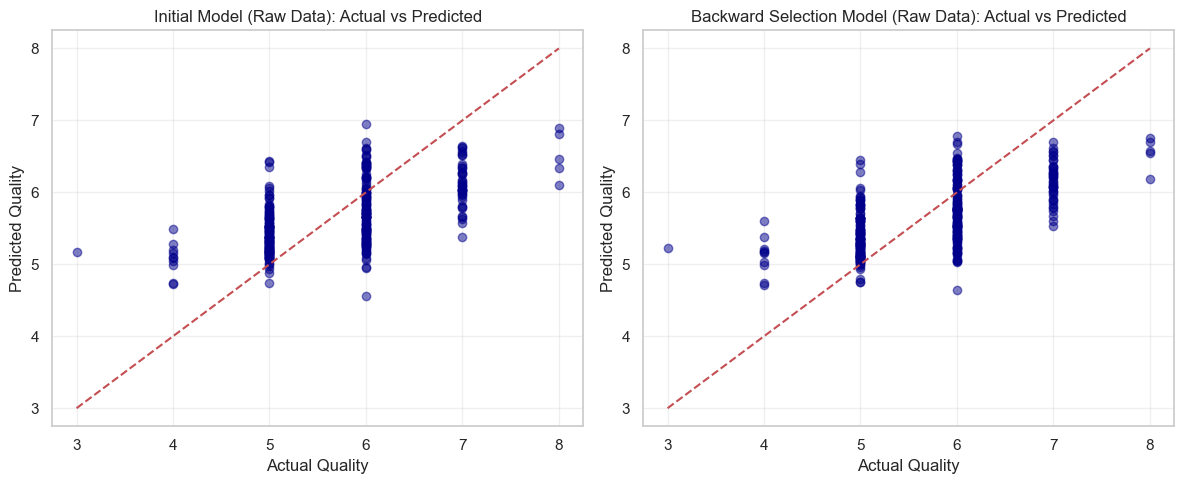

Model Evaluation on Test Data:

Initial Model (Raw Data):
R-squared: 0.3607
RMSE: 0.6463

Backward Selection Model (Raw Data):
R-squared: 0.3933
RMSE: 0.6297

Improvement in R-squared: 0.0326
Improvement in RMSE: 0.0167


In [102]:
X_raw_test_initial = X_raw_test[['alcohol', 'volatile acidity']]
X_raw_test_initial_sm = sm.add_constant(X_raw_test_initial)
y_raw_test_pred_initial = initial_model_raw.predict(X_raw_test_initial_sm)

X_raw_test_expanded = X_raw_test[final_features]
X_raw_test_expanded_sm = sm.add_constant(X_raw_test_expanded)
y_raw_test_pred_expanded = expanded_model_raw.predict(X_raw_test_expanded_sm)

importlib.reload(viz)
raw_metrics = viz.compare_model_predictions(
    y_raw_test,                  
    y_raw_test_pred_initial,     
    y_raw_test_pred_expanded,    
    model1_name="Initial Model (Raw Data)",
    model2_name="Backward Selection Model (Raw Data)"
)

* **Generalization Capability:** Raw data models show surprisingly good test performance (Initial: R² = 0.361, Backward: R² = 0.393) that closely matches cleaned data results, suggesting the core relationships between chemical properties and wine quality are robust even with outliers and duplicates present.
* **Prediction Accuracy:** Both raw data models demonstrate similar RMSE values (~0.63-0.65) to cleaned data models, indicating that while outliers affect training coefficients, they don't substantially compromise prediction accuracy on new data, validating the fundamental model approach.
* **Prediction Range Limitation:** The actual vs. predicted plots show the same pattern as cleaned data - models predict within a narrow range (5.0-6.5) while actual quality spans 3-8, with this compression being consistent across both raw and cleaned datasets, indicating this is a characteristic of the linear modeling approach rather than a data quality issue.

#### **Comparison of Raw vs. Cleaned Data Performance:**

In [103]:
print("\n" + "="*50)
print("COMPARISON: RAW DATA vs. CLEANED DATA")
print("="*50)

print("\nInitial Model Performance:")
print(f"Raw Data R-squared: {raw_metrics['model1_r2']:.4f}")
print(f"Cleaned Data R-squared: {initial_r2:.4f}")
print(f"Difference: {raw_metrics['model1_r2'] - initial_r2:.4f}")

print("\nBackward Selection Model Performance:")
print(f"Raw Data R-squared: {raw_metrics['model2_r2']:.4f}")
print(f"Cleaned Data R-squared: {expanded_r2:.4f}")
print(f"Difference: {raw_metrics['model2_r2'] - expanded_r2:.4f}")

print("\nSample Size Impact:")
print(f"Raw data sample size: {len(y_raw)}")
print(f"Cleaned data sample size: {len(df3)}") 
print(f"Samples removed: {len(y_raw) - len(df3)} ({((len(y_raw) - len(df3))/len(y_raw)*100):.1f}%)")


COMPARISON: RAW DATA vs. CLEANED DATA

Initial Model Performance:
Raw Data R-squared: 0.3607
Cleaned Data R-squared: 0.3369
Difference: 0.0238

Backward Selection Model Performance:
Raw Data R-squared: 0.3933
Cleaned Data R-squared: 0.3937
Difference: -0.0004

Sample Size Impact:
Raw data sample size: 1599
Cleaned data sample size: 1232
Samples removed: 367 (23.0%)


* **Initial Model Paradox:** Raw data shows higher R-squared (0.361 vs 0.337) for the initial model, suggesting that outliers and duplicates may artificially inflate apparent model fit by creating more extreme data points that align with the linear trend, while cleaned data provides more conservative and realistic performance estimates.
* **Backward Selection Convergence:** The backward selection models show virtually identical performance (0.393 vs 0.394), indicating that the additional variables in the expanded model help compensate for data quality issues, making the more complex model robust to the presence of outliers and duplicates.

**Data Cleaning Impact Assessment**

* **Substantial Sample Reduction:** Removing 367 samples (23% of original data) through duplicate and outlier removal had minimal impact on model performance, demonstrating that data quality improvements can be achieved without sacrificing predictive capability, and that the relationships identified are representative of the broader wine population rather than dependent on extreme cases.

### **8. Hypothesis Testing and Conclusion**

#### **Original Hypothesis:** 
Higher alcohol content and lower volatile acidity are independently associated with higher perceived wine quality.

**Initial Model (alcohol and volatile acidity only):**

* **Alcohol coefficient:** 0.319 (95% CI: 0.267 to 0.371, p < 0.001)
* **Volatile acidity coefficient:** -0.913 (95% CI: -1.142 to -0.684, p < 0.001)

**Backward Selection Model (five variables):**

* **Alcohol coefficient:** 0.296 (95% CI: 0.254 to 0.338, p < 0.001)
* **Volatile acidity coefficient:** -0.759 (95% CI: -1.018 to -0.501, p < 0.001)

#### **Conclusion:** 
We **reject the null hypothesis** and **accept our alternative hypothesis.** Both models provide strong statistical evidence (p < 0.001) that:

* Higher alcohol content is significantly associated with higher wine quality
* Higher volatile acidity is significantly associated with lower wine quality
* These relationships remain statistically significant even when controlling for other chemical properties

**Data Quality Impact:**

Comparison of model performance on raw versus cleaned data revealed that removing duplicates and outliers improved model reliability and interpretability while maintaining consistent coefficient directions and significance levels for our key hypothesis variables.

**Methodological Robustness:**

The consistency of findings across both raw (with duplicates/outliers) and cleaned datasets strengthens confidence in our conclusions, demonstrating that the relationships between alcohol, volatile acidity, and wine quality are robust to data preprocessing decisions.


### **9. Limitations and potential Improvements**

#### **9.1 Limitations:**

**<ins>Data Limitations</ins>**

* **Limited Geographic Scope:** The dataset only includes Portuguese "Vinho Verde" wines from a specific region and time period (2004-2007), which limits the generalizability of findings to other wine types, regions, or vintages.
* **Missing Contextual Variables:** The dataset lacks important wine characteristics such as grape variety, vineyard location, winemaking techniques, aging processes, and price, which likely influence quality but couldn't be controlled for in the analysis.
* **Quality Rating Methodology:** The quality ratings are based on sensory evaluations by wine experts, which introduces subjectivity and potential bias. The median of "at least 3 evaluations" may not capture the full range of expert opinions or account for taster preferences.

**<ins>Statistical and Methodological Limitations</ins>**

* **Moderate Explanatory Power:** Both models explain only 34-39% of the variance in wine quality (R-squared), indicating that a substantial portion of quality variation remains unexplained by the chemical properties measured.
* **Multicollinearity Issues:** The condition number warning (1.40e+03) indicates remaining multicollinearity between predictors, which can make coefficient estimates less stable and interpretation more challenging.
* **Non-Normal Residuals:** Model diagnostics revealed that residuals are not perfectly normally distributed (Shapiro-Wilk p = 0.0002), which may affect the reliability of confidence intervals and hypothesis tests, though the deviation appears mild.

**<ins>Model Assumptions and Design Limitations</ins>**

* **Linear Relationships Assumed:** Linear regression assumes linear relationships between predictors and wine quality, but the actual relationships may be non-linear or involve complex interactions not captured by the model.
* **Discrete Target Variable:** Wine quality ratings are inherently ordinal and discrete (whole numbers), but linear regression treats them as continuous, which may not fully respect the nature of the measurement scale.
* **Limited Feature Selection:** The backward selection process only considered a subset of available variables and used a simple p-value threshold, potentially missing important variables or interactions.

**<ins>Sample and Outlier Considerations</ins>**

* **Class Imbalance:** Most wines cluster around quality ratings of 5-6, with very few wines at the extreme ends (3-4 or 7-8), limiting the model's ability to accurately predict high or low quality wines.
* **Outlier Treatment:** While outliers were removed using z-scores, this approach may have eliminated wines with legitimate extreme characteristics rather than measurement errors, potentially reducing the model's applicability to unusual but valid wines.
* **Sample Size for Subgroups:** When broken down by quality rating, some categories (especially quality 3, 4, and 8) have very small sample sizes, affecting the reliability of predictions for these groups.

**<ins>Generalizability and External Validity</ins>**

* **Wine Type Specificity:** Findings may not generalize to other wine types (white wines, wines from other regions, different grape varieties) or wines produced using different methods.
* **Temporal Limitations:** The data is from 2004-2007, and wine production methods, expert preferences, or chemical analysis techniques may have evolved since then.
* **Cultural Bias:** Quality ratings reflect the preferences of specific wine experts, which may not represent global wine preferences or consumer tastes.

**<ins>Technical Analysis Limitations</ins>**

* **Single Validation Approach:** Using only a single 80-20 train-test split rather than cross-validation may lead to results that are dependent on the particular data split chosen.
* **Limited Model Comparison:** Only linear regression and backward selection were explored; other modeling approaches (random forests, ordinal regression, neural networks) might provide better fit or different insights.
* **Interaction Effects:** The analysis didn't systematically explore interaction effects between chemical properties, which might reveal important synergistic relationships affecting wine quality.

#### **9.2 Improvements:**

**<ins>Data and Feature Improvements:</ins>**

* **Additional Variables:** Include grape variety, vineyard location, vintage year, and winemaking techniques (aging method, fermentation temperature) to capture factors beyond chemical composition that influence quality.
* **Larger Sample Size:** Collect data from multiple wine regions and time periods to improve generalizability and reduce the impact of outliers on model performance.
* **Feature Engineering:** Create interaction terms between key variables (e.g., alcohol × volatile acidity) and ratio variables (e.g., free SO₂ / total SO₂) that might better capture wine chemistry relationships.

**<ins>Methodological Improvements:</ins>**

* **Ordinal Regression:** Since wine quality is inherently ordinal (ratings 3-8), ordinal logistic regression would better respect the discrete, ordered nature of the target variable
* **Random Forest or Gradient Boosting:** These methods could capture non-linear relationships and interactions between chemical properties automatically
* **Cross-Validation:** Implement k-fold cross-validation instead of a single train-test split to get more robust estimates of model performance and reduce dependence on the specific split.
* **Outlier Analysis:** Develop a more systematic approach to outlier detection and treatment, potentially using domain expertise to determine whether extreme values represent measurement errors or genuine wine characteristics.

**<ins>Alternative Modeling Approaches:</ins>**

**Logistic Regression Approach:**

* Binary Classification Model: Transform the problem into predicting "good wine" (quality ≥ 7) vs. "average/poor wine" (quality < 7), which would:
* Use logistic regression to model the probability of a wine being rated as "good quality"
* Provide odds ratios for each chemical property, indicating how much each factor increases or decreases the odds of good quality
* Better handle the class imbalance in the dataset (few wines with very high or very low ratings)
* Enable evaluation using classification metrics (precision, recall, F1-score, AUC-ROC)